<a href="https://colab.research.google.com/github/oliviajakli/oliviajakli/blob/main/SINGLE_SaB_BlueBand_SingleDerivative_Sentinel2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Variable Band 6 component VPCA Spectral Decomposition code for Sentinel 2A/B MSI**

This code applies the KSU VPCA decomposition method to the ten 10m and 20m Sentinel 2A/B (S2A/B) VSWIR bands present in the GEE Sentinel 2 Surface Reflectance collection, which includes data from 2A and 2B https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR
This yields a total of 20 bands for the combined surface reflectance and derivatives. The two sensors have wavelength centers that differ by 1-2nm in ll bands except for B12, which differs by 8nm due to instrument fabriction differences. This code uses nominal band centers based on the average of the band centers from each instrument. If issues are noted, the data can be harmonized to the band spacing for S2A or S2B. All bands are resampled to 10m spatial resolution for commbined sectral analysis. Verify the code has been modified correctly for 20 bands. Add revised code to input S2A/B data and filter water pixels using S2A/B quality flags

# Imports and Authorizations

In [1]:
# Imports used in this notebook.
import matplotlib as mpl
import ee
import folium
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
from ee import batch
from matplotlib import cm
from google.colab import drive
from pprint import pprint as pp
from uuid import uuid1 as uniqueID

# Must authenticate your EE account before use of the package.
ee.Authenticate()
ee.Initialize(project='ksu-skytruth-vpca-automation')

# This is how we can access our drive to get the correlation product.
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# For visualizing intermediary products

In [2]:
# JOE: I am saving colormaps to variables here.
# https://stackoverflow.com/questions/33596491/extract-matplotlib-colormap-in-hex-format

def hex_colormap(palette_name = None):
  # "palette_name" must be a string.
  ramp = cm.get_cmap(palette_name)
  # Converts color values to hexadecimal format so we can use them.
  ramp_ls = [mpl.colors.rgb2hex(ramp(color)[:3]) for color in range(ramp.N)]

  return ramp_ls
# See a full list of colormaps here: https://matplotlib.org/stable/tutorials/colors/colormaps.html
#perceptually uniform colormps
viridis = hex_colormap('viridis')
inferno = hex_colormap('inferno')
magma = hex_colormap('magma')
gist_gray = hex_colormap('gist_gray')

#divergent (Add _r to invert the color ramp)
BrBG = hex_colormap('BrBG')
spectral = hex_colormap('Spectral_r')
coolwarm = hex_colormap('coolwarm')
seismic = hex_colormap('seismic')

BrBG_r = hex_colormap('BrBG_r')
spectral_r = hex_colormap('Spectral_r')
coolwarm_r = hex_colormap('coolwarm_r')
seismic_r = hex_colormap('seismic_r')

<ipython-input-2-4efa02626385>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ramp = cm.get_cmap(palette_name)


In [3]:
# Function to find the tails of the pdf
# This returns the tails of the pdf for the image with values from p0-p10, and p90-p100
# This allows the user to select a range of min-max values as plotting limits

def minAndMax(image,region = None):

  # Find the minimum number.
  min_reducer = image.reduceRegion(
      reducer = ee.Reducer.percentile([0,1,2,3,4,5,6,7,8,9,10,90,91,92,93,94,95,96,97,98,99,100],['p0','p1','p2','p3','p4','p5','p6','p7','p8','p9','p10','p90','p91','p92','p93','p94','p95','p96','p97','p98','p99','p100']),
          scale = 10,
          geometry = region,
          bestEffort = True)

  orig_keys = min_reducer.keys()

  min_reducer = min_reducer.rename([orig_keys.get(0),orig_keys.get(1),orig_keys.get(2),orig_keys.get(3),orig_keys.get(4),orig_keys.get(5),orig_keys.get(6),orig_keys.get(7),orig_keys.get(8),orig_keys.get(9),orig_keys.get(10),orig_keys.get(11),orig_keys.get(12),orig_keys.get(13),orig_keys.get(14),orig_keys.get(15),orig_keys.get(16),orig_keys.get(17),orig_keys.get(18),orig_keys.get(19),orig_keys.get(20),orig_keys.get(21)],['p0','p1','p2','p3','p4','p5','p6','p7','p8','p9','p10','p90','p91','p92','p93','p94','p95','p96','p97','p98','p99','p100'])

  return min_reducer

# Select an AOI

In [4]:
# Method 2: Import and Mosaic adjacent images from same path

# Browse for images using the EO Browser: https://www.sentinel-hub.com/explore/eobrowser/
#
# Note: Sentinel 2 A/B each fly over the same location every 5 days. When you find an image that covers the
# ROI, count by fives in the EO Broswer to find repeat flyovers of that same ROI
# If part of the ROI is cutoff by a swath edge, you can select a 3-day offset from the start date to mosaic the two swaths closes in time.
#


# Sandusky Bay
siteName = 'Sandusky Bay'
siteName_2char = 'SB'
upperLeft = [ -83.20, 41.55 ]
lowerRight = [ -82.575, 41.36 ]
#dateRange = ['2021-08-22', '2021-08-23'] # 4.6% cloud cover; mostly over land
#dateRange = ['2021-09-06', '2021-09-07'] # 0.4% cloud cover
dateRange = ['2021-05-14', '2021-05-15'] # 1.8% cloud cover; some puffy ones over land
# TEST dateRange = ['2020-05-04', '2020-05-05'] # 1.5% cloud cover but looks like lots
#dateRange = ['2020-06-08', '2020-06-09'] # 0% cloud cover
#dateRange = ['2021-07-18', '2021-07-19'] # 0% cloud cover
#dateRange = ['2022-06-18', '2022-06-19'] # 0% cloud cover
#dateRange = ['2023-09-01', '2023-09-02'] # only clear day in September (below 20% cloud cover)



#dateRange = ['2021-04-05', '2021-04-08'] # Selecting a 3-day offset makes a mosaic of the swaths closest in time.

# Select our S2 imagery


In [5]:
# Start Standard code for processing images from a collection.

# Define a region of interest to filter our collection.
roi = ee.Geometry.Rectangle(upperLeft[0], upperLeft[1], lowerRight[0], lowerRight[1])
# Bring in our imagery.
#coll = ( ee.ImageCollection('COPERNICUS/S2_SR')
coll = (ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
            .filterBounds(roi)
            .filterDate(dateRange[0], dateRange[1])
            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',90)) )

# Clip the mosaic to the exact bounds of the region of interest
water = coll.mosaic()

def getGeom(img):
 return ee.Feature(img.geometry())

# Apply the above function to all of the images in our collection.
geoms = ee.FeatureCollection(coll.map(getGeom))
# Return the union of the geometries retrieved from our collection.
union = geoms.union()
# Get the center of our mega-geometry for plotting purposes.
lon_lat = roi.centroid().getInfo()['coordinates']
# Clip our input image to our region of interest.
water = water.clip(roi)

# End standard code for processing images from a collection.

Generate RGB Image

In [6]:
# Visualize the scene in natural color

b_minMax = minAndMax(water.select('B3'),roi)
#mapid = water.getMapId({'bands': ['B4', 'B3', 'B2'], 'min':b_minMax.get('p5'),'max':b_minMax.get('p95') }) # Where "water" is specified, switch this out with whatever you want to visaulize.
mapid = water.getMapId({'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 2000}) # Where "water" is specified, switch this out with whatever you want to visaulize.
map = folium.Map(location = [lon_lat[1],lon_lat[0]], zoom_start = 10.0, control_scale = True)

orig = folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
  )

orig.add_to(map)

# Give our map a label.
imageID = f'S2_{dateRange[0]}'

# Add a title to the map;
map.add_child(folium.LayerControl())
title_html = f'''
             <h3 align="left" style="font-size:16px"> <b>Sentinel 2 A/B MSI {siteName} RGB: {imageID}</b></h3>
             '''
map.get_root().html.add_child(folium.Element(title_html))

map

# Begin analysis

In [14]:
"""This section is devoted to modifying the image, making it suitable for
   the Derivative Spectra function, and running the DS function."""

# Parse out the water pixels in Sentinel 2 A/B MSI image.

# This function masks the cloudy pixels and identifies the water pixels.
def get_water(image):

  # QA60 is the cloud mask (Bits 10 and 11 should be zero for clear conditions).
  # SCL is the Scene Classification Layer SCL 6 is water.
  # Use the following bits to extract water pixels.

  # Water with cloud check, but note this is not bit the addition method.
  water_pixels = (image.select('QA60').eq(0).And(image.select('SCL').eq(6)))

  # Mask all non-water pixels in the image.
  image = image.updateMask(water_pixels)

  return image

# Run the Sentinel 2 A/B MSI mask on the test images.
water_mask = get_water(water)

# Binary reducer, which returns 1 everywhere that water hasn't been masked.
mask_image = water_mask.reduce(ee.Reducer.anyNonZero())

# Any pixels passing the pixel mask will now be polygonized.
water_geom = mask_image.reduceToVectors(scale = 10, maxPixels = 1e10, bestEffort = True)

# Add a coastal buffer of 3 pixels = 30 meters
#water_geom = water_geom.map(lambda image: image.buffer(-30))

In [ ]:
""" Bands and Wavelength Array to select. You can add or subtract any you'd like here and the code
    below will account for the change throughout the workflow. """

# Include all 12 bands
#
#bandCombo="allBands"
#non_ee_band_list = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']
#wl = ee.Array([443.9,496.6,560.0,664.5,703.9,740.2,782.5,835.1,864.8,945,1613.7,2202.4])

# Include 10m and 20m bands only
#
#bandCombo="no60m"
#non_ee_band_list = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']
#wl = ee.Array([496.6,560.0,664.5,703.9,740.2,782.5,835.1,864.8,1613.7,2202.4])

# Add B1, the ulta blue band
#
#bandCombo="add_B1"
#non_ee_band_list = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']
#wl = ee.Array([443.9,496.6,560.0,664.5,703.9,740.2,782.5,835.1,864.8,1613.7,2202.4])

# Add B9, the 60m NIR water vapor band at 945nm
#
#bandCombo="add_B9"
#non_ee_band_list = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']
#wl = ee.Array([496.6,560.0,664.5,703.9,740.2,782.5,835.1,864.8,945,1613.7,2202.4])

#bandCombo="B2-B8A"
#non_ee_band_list = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A']
#wl = ee.Array([496.6,560.0,664.5,703.9,740.2,782.5,835.1,864.8])

bandCombo="B1-B8A"
non_ee_band_list = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A']
wl = ee.Array([443.9,496.6,560.0,664.5,703.9,740.2,782.5,835.1,864.8])
# wl = ee.Array([442.7,492.7,559.8,664.4,704.1,740.5,782.8,832.8,864.7])
""" JOE: See these variables. We will use these instead of hard-coding
    the number of bands. """

# Use this for the derivative calculation.
band_list_early_length = len(non_ee_band_list)
# We use this everywhere else after the derivative calc (original band list x2).
band_list_length = len(non_ee_band_list)
# Use this in a couple for loops throughout the code.
band_list_forLoops = range(len(non_ee_band_list) )

"""*******************"""

# This function will select the bands of importance and clip the raster.
def selAndClip(masked_image,geo):

  clipped = masked_image.select(non_ee_band_list).clip(geo)

  return clipped.toDouble()

# Run the select and clip function on the test images, converts the pixels values to double precision.
clipped_image = selAndClip(water_mask,water_geom)

# Add code below to divide the reflectance bands by 10^4 to scale from 0 to 1
clipped_image = clipped_image.multiply(0.0001)

def derivativeSpectra(img,numBands):

  drdlraster = None

  for i in range(numBands):

    # Special case of the equation is required for the first band.
    if i == 0:
      drdlraster = img.expression(
        '(secondBand - firstBand)/(secondIndex - firstIndex)',
        {
        'secondBand': img.select(i+1),
        'firstBand': img.select(i),
        'secondIndex': wl.get([i+1]),
        'firstIndex': wl.get([i])
        }).rename('image_Index' + str(i) + '_derivative')

    # Special case of the equation is required for the last band.
    elif i == (numBands-1):

      drdlraster = img.expression(
        '(secondBand - firstBand)/(secondIndex - firstIndex)',
        {
        'secondBand': img.select(i),
        'firstBand': img.select(i-1),
        'secondIndex': wl.get([i]),
        'firstIndex': wl.get([i-1])
        }).rename('image_Index' + str(i) + '_derivative')

    # Apply equation for all other bands in the image.
    else:
      drdlraster = img.expression(
        '(secondBand - firstBand)/(secondIndex - firstIndex)',
        {
        'secondBand': img.select(i+1),
        'firstBand': img.select(i-1),
        'secondIndex': wl.get([i+1]),
        'firstIndex': wl.get([i-1])
        }).rename('image_Index' + str(i) + '_derivative')

    # Adds derivative bands to the input image.
    img = img.addBands(drdlraster)

  # JDO Modified this line to return only the derivative bands, cast to a new image.
#  return img.set({'name': water.get('name')}).select(8,9,10,11,12,13,14,15)

# JDO Modified this line to return only the derivative bands adding band 16 after adding B1 to the list above; cast to a new image.
  return img.set({'name': water.get('name')}).select(8,9,10,11,12,13,14,15,16)
# Apply a Gaussian smoother to the image to reduce high frequency noise
#smooth_kernel hold the kernel function; select various odd values to change the kernel size.
  smooth_kernel = ee.Kernel.gaussian(radius = 3)
# apply the smoothing kernal using the ee.convolve function
  d_image = d_image.convolve(smooth_kernel)

# Run the Derivative Spectra function on the test image.
d_image = derivativeSpectra(clipped_image,band_list_early_length)

# Smooth the derivative image next

In [ ]:
# Apply a Gaussian smoother to the image to reduce high frequency noise
# smooth_kernel hold the kernel function; select various odd values to change the kernel size.
smooth_kernel = ee.Kernel.gaussian(radius = 5)
# apply the smoothing kernal using the ee.convolve function
d_image = d_image.convolve(smooth_kernel)

# Determine Correlation Matrix for image

In [ ]:
"""The following section is devoted to the correlation matrix
   creation process, as well as the eigen analysis."""

def pearCorr(img, starting_band_index):

  # This is distinct from the other list of band names because this is an EE object.
  # Therefore, this can utilize EE-side functions, like get().
  band_list = img.bandNames()

  # This will be filled with correlation values.
  emptyList = ee.List([])

  # Loop through band names. You no longer have to change this manually.
  for i in band_list_forLoops:

    # Get band name based on index.
    corr_band = band_list.get(i)

    # Select the defined band from the input image.
    one = img.select([starting_band_index])

    # Select the second band of interest.
    two = img.select([corr_band])

    # Combine the two selected bands into a new image.
    cat = ee.Image.cat(one, two)

    # Compute the correlation between the bands in the newly created image.
    corr = cat.reduceRegion(
               reducer = ee.Reducer.pearsonsCorrelation(),
               geometry = img.geometry(),
               scale = 10,
               maxPixels = 1e7,
               bestEffort = True
               )

    # Get the correlation value out of the reduceRegion() dictionary.
    corr_value = corr.getNumber('correlation')

    # Push the new correlation value into our empty list.
    emptyList = emptyList.add(corr_value)

  return emptyList

In [ ]:
# List comprehension to compile all of our correlation values.
corr_ls = ee.Feature(None, {'correlation_list':[pearCorr(d_image, i) for i in band_list_forLoops]})

#runtime_filename = f'correlation_product_{uniqueID()}'
runtime_filename = f'6VPCA_{siteName_2char}_{imageID}_correlation_{bandCombo}'

intermission = ( batch.Export.table.toDrive(
                 collection = ee.FeatureCollection(corr_ls),
                 description = runtime_filename,
                 folder = 'KSU_VPCA_Outputs',
                 fileFormat = 'CSV') )

batch.Task.start(intermission)

# Monitor the task.
i = 1
while intermission.status()['state'] in ['READY', 'RUNNING']:
  sys.stdout.write("\r" + f'Correlation export status update #{i}: ' + str(intermission.status()))
  sys.stdout.flush()
  i += 1
  time.sleep(10)
else:
  print('Correlation export completed...')
  print(intermission.status())
  time.sleep(10)

Correlation export status update #4: {'state': 'RUNNING', 'description': '6VPCA_SB_S2_2021-08-22_correlation_B1-B8A', 'priority': 100, 'creation_timestamp_ms': 1716570133055, 'update_timestamp_ms': 1716570139354, 'start_timestamp_ms': 1716570139263, 'task_type': 'EXPORT_FEATURES', 'attempt': 1, 'id': 'I35XU66RYL2DOYZ77FV3PJLP', 'name': 'projects/ksu-skytruth-vpca-automation/operations/I35XU66RYL2DOYZ77FV3PJLP'}Correlation export completed...
{'state': 'COMPLETED', 'description': '6VPCA_SB_S2_2021-08-22_correlation_B1-B8A', 'priority': 100, 'creation_timestamp_ms': 1716570133055, 'update_timestamp_ms': 1716570171656, 'start_timestamp_ms': 1716570139263, 'task_type': 'EXPORT_FEATURES', 'destination_uris': ['https://drive.google.com/#folders/1rNt_PXA6s4-J7eOg4Yyvg_xbrwMkyomh'], 'attempt': 1, 'batch_eecu_usage_seconds': 4226.09423828125, 'id': 'I35XU66RYL2DOYZ77FV3PJLP', 'name': 'projects/ksu-skytruth-vpca-automation/operations/I35XU66RYL2DOYZ77FV3PJLP'}


# Eigenvalue-Eigenvector Decomposition

In [ ]:
# Generate the string needed to read back in the correlation file for this image, which we have saved to disk earlier
drive_string = f'/content/gdrive/My Drive/KSU_VPCA_Outputs/{runtime_filename}.csv'

# Read in any correlation matrix for a specific day or average (Change the date for the desired day)
#drive_string = f'/content/gdrive/My Drive/KSU_VPCA_Outputs/6VPCA_BB Avg_S2_2021-05-05_correlation_B2-B8A.csv'

import pandas as pd
dataframe = pd.read_csv(drive_string, delimiter = ',', converters = {'correlation_list': eval})

In [ ]:
corr_ls = dataframe['correlation_list'].tolist()[0]

In [ ]:
# Note: This code block to average multiple correlation matricies is not yet working.

# Code to read in and average two correlation matrices
#drive_string1 = f'/content/gdrive/My Drive/KSU_VPCA_Outputs/6VPCA_BB_S2_2021-05-05_correlation_B2-B8A.csv'
#drive_string2 = f'/content/gdrive/My Drive/KSU_VPCA_Outputs/6VPCA_BB_S2_2021-05-15_correlation_B2-B8A.csv'
#print(drive_string1)
#print(drive_string2)

#import pandas as pd
#dataframe1 = pd.read_csv(drive_string1, delimiter = ',', converters = {'correlation_list': eval})
#dataframe2 = pd.read_csv(drive_string2, delimiter = ',', converters = {'correlation_list': eval})

# Average the two data frames and output as corr_ls
# Note, this should provide the element-wise average, but it assumes an equal number of pixels in both images, so we can improve by weighting the two correlation matrices
# their relative number of pixels.

# This code is not synatatically correct because the data frames are lists of strings.
# We need to convert them to arrays and convert the elements to float
#dataframe_sum = (dataframe1 + dataframe2)

#dataframe_avg = []
#for number in dataframe_sum:
#   dataframe_avg.append(number / 2.0)

#corr_ls = dataframe_avg['correlation_list'].tolist()[0]


In [ ]:
for row in corr_ls:
 print(row)

[1.0, -0.06293123438696949, 0.01843988077521181, 0.3556456778243509, 0.5105488492035701, 0.6515287008558298, 0.2676496338735655, 0.16498621924427678, 0.022759828826248447]
[-0.06293123438697935, 0.9999999999999999, 0.7193731713583885, 0.10479229295802601, -0.08637732666838428, -0.38326336218323626, -0.32582522549143184, 0.028116910720395627, -0.23464385663021922]
[0.018439880775235548, 0.7193731713583926, 0.9999999999999999, 0.6065661848441354, 0.2780643531465049, -0.579531258174491, -0.757879029863419, -0.2847741127041357, -0.6411661427650684]
[0.3556456778243477, 0.10479229295802799, 0.6065661848441526, 1.0, 0.8781350647823819, -0.2306560072265979, -0.675489293190299, -0.3580674029644079, -0.7497948237043301]
[0.5105488492035682, -0.08637732666837429, 0.2780643531465181, 0.8781350647823207, 1.0, 0.10165767384780323, -0.4455644924850827, -0.30594090904129506, -0.6610854903854485]
[0.65152870085583, -0.3832633621832353, -0.5795312581745384, -0.23065600722664883, 0.10165767384780668, 1.

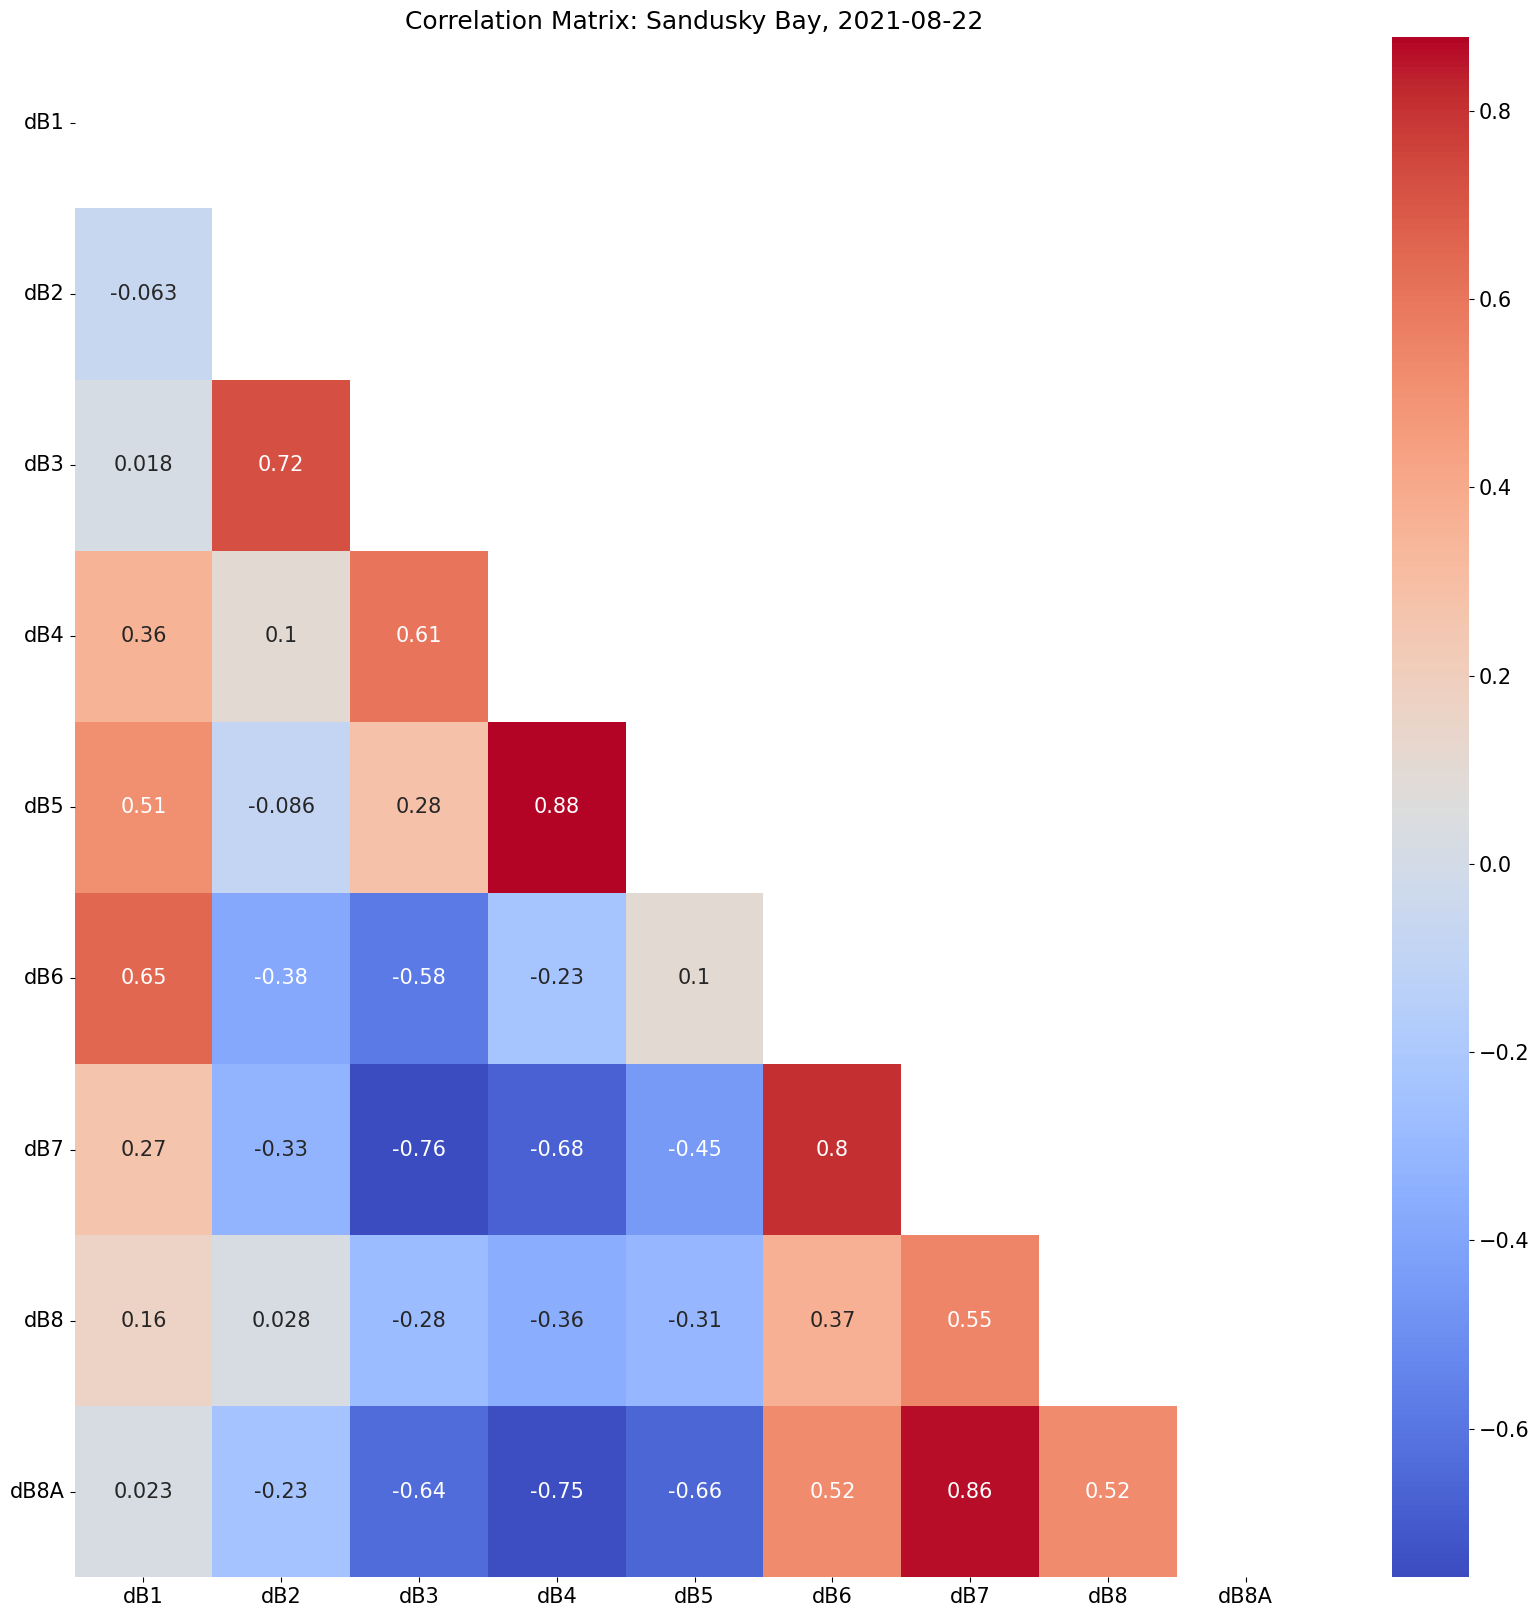

In [ ]:
# Initially found here: https://stackoverflow.com/questions/33282368/plotting-a-2d-heatmap-with-matplotlib

# Create a 2D heat map using Seaborn.
import seaborn as sea

# Set the default font size in matplotlib
mpl.rcParams.update({'font.size': 15})

#labels = [f'r{non_ee_band_list[x]}' for x in range(10)] + [f'd{non_ee_band_list[x]}' for x in range(10)]
# Use this code to allow for differing number of bands processed
labels = [f'd{non_ee_band_list[x]}' for x in range(band_list_early_length)] #+ [f'd{non_ee_band_list[x]}' for x in range(band_list_early_length)]

mask = np.zeros_like(corr_ls)

mask[np.triu_indices_from(mask)] = True

fig = plt.figure(figsize = (20,20))
heat = sea.heatmap(corr_ls, square = False, mask = mask, cmap = 'coolwarm', annot = True)
heat.set_xticklabels(labels)
heat.set_yticklabels(labels)

for tick in heat.get_yticklabels():
  tick.set_rotation(0)

heat.set_title(f"Correlation Matrix: {siteName.replace('_', ' ')}, {imageID.replace('S2_','')}")

plt.savefig(f'/content/gdrive/My Drive/KSU_VPCA_Outputs/{runtime_filename}_viz.jpg')

plt.show()

In [ ]:
# Eigenvalues and eigenvectors calculated using Numpy.
eigens = np.linalg.eigh(corr_ls)

# Extract the eigenvalues from eigens so that we can reverse the sort
eigenVals = eigens[0]

# Reverse the eigenvalue sort so that they are in descending order
eigenVals = eigenVals[::-1]
# Convert to EE.
eigenVals = ee.List(list(eigenVals))
print('Print the Eigenvalues')
print(eigenVals.getInfo(),'\n')

# Build the eigenvector matrix
# Rotate the eigenvector matrix 180 to place it in the correct orientiation to match
# the eigenvalues sorted in descending order
rotating = np.rot90(eigens[1],2)
#print('Oriented EigenVectors\n',rotating)
# needed to add the last 7 eigenvectors

eigenVecs = ee.Array.cat([ee.Array(list(rotating[i])) for i in range(len(rotating))])

# Reformat the array. May need to be multiplied by -1.
# This calculation has proven to be finicky using both EE and Numpy.
# JDO increase the size of the eigenvector matrix to 20x20
eigenVecs = eigenVecs.reshape([band_list_length,band_list_length]).transpose()

# Check your eigenvector matrix below.
print('Print Unrotated Eigenvector matrix (Prior to VARIMAX rotation)')
for row in eigenVecs.getInfo():
  print(row)

Print the Eigenvalues
[4.389130234036127, 2.250304782693315, 1.2928192336695568, 0.5462392208226612, 0.2316398534986701, 0.15191642045950485, 0.09513538848113366, 0.041568168016315965, 0.0012466983227182823] 

Print Unrotated Eigenvector matrix (Prior to VARIMAX rotation)
[-0.4363674838013635, -0.27572052551764553, -0.4550746332950141, -0.3192905741506347, 0.2825768260582454, 0.3848701698088775, 0.3958079769784892, 0.19709197434390058, -0.032222772299441794]
[-0.0843107139920073, 0.023668932726860326, 0.12279131785519176, 0.4496286248230161, 0.5040506020626775, 0.34435933988931733, -0.09830495563680391, -0.24502607551978817, 0.5768326193383502]
[0.11595835233889307, 0.47363934985802264, 0.10827740093819044, 0.10056746142893108, -0.09326480795045738, 0.009254435751233997, 0.4123033254946046, 0.6735948637947222, 0.3284411289852104]
[-0.12332575468868998, 0.8261268831259378, -0.1619585457748185, -0.228578737500921, 0.151721477801334, 0.20877353838074597, -0.11614716523670604, -0.292905048

# Pre-process for VARIMAX Rotation

In [ ]:
"""The following section is devoted to pre-processing
   the data for the Varimax Rotation."""

# Determine whether or not each eigenvalue is positive.
def checkEigs(eig):
    # Cast to an ee Number.
    eig = ee.Number(eig)
    check = ee.Algorithms.If(eig.lt(0),eig.multiply(-1),eig.multiply(1))
    return check

# All eigenvalues should now be positive.
eigenVals = eigenVals.map(checkEigs)

# Determine Square root of all eigenvalues to obtain the singular values
singvalue = ee.Array(eigenVals).sqrt()

def formatData(rows,value):
  new_list = ee.List([])

# Slice array and multiply by each row's respective positive eigenvalue.
  for i in band_list_forLoops:
    sliver = ee.Algorithms.If(ee.Number(i).eq(band_list_length - 1), rows.slice(0,i).multiply(value.get([i])),
                                                  rows.slice(0,i,i+1).multiply(value.get([i])))
    # Push formatted rows into new empty list.
    new_list = new_list.add(sliver)
  return new_list

# Get our formatted information.
pcaload = formatData(eigenVecs,singvalue)

# Select the top three principal components for the rotation.

pc1 = pcaload.getArray(0).project([1]).toList()
pc2 = pcaload.getArray(1).project([1]).toList()
pc3 = pcaload.getArray(2).project([1]).toList()

# Second batch of PCs.
pc4 = pcaload.getArray(3).project([1]).toList()
pc5 = pcaload.getArray(4).project([1]).toList()
pc6 = pcaload.getArray(5).project([1]).toList()

# Create the input arrays for rotation.
varimaxInput_1 = ee.Array([pc1,pc2,pc3]).transpose()

varimaxInput_2 = ee.Array([pc4,pc5,pc6]).transpose()

# VARIMAX Rotation Routine

In [ ]:
"""Section devoted to performing the Varimax Rotation."""

# This function is used to restructure the array after each pass through the rotation loop.
def vpca_toArray(initArr, a, b, xRot, yRot):
  # Values of "i" and "j" are checked to return a new, reformatted version of the input array.
  if a == 0 and b == 1:
    initArr = ee.Array.cat([xRot,yRot,initArr.slice(1,2,3)],1)
  elif a == 0 and b == 2:
    initArr = ee.Array.cat([xRot,initArr.slice(1,1,2),yRot],1)
  elif a == 1 and b == 2:
    initArr = ee.Array.cat([initArr.slice(1,0,1),xRot,yRot],1)
  else:
    initArr = initArr
  return initArr

def varimax_rotation(input):

  epsilon = ee.Number(2 * 0.00001)

  # Sqrt of communality.
  # (Communality: the proportion of variance that each item has in common with other items.)
  h = ((input.pow(2)).reduce(reducer=ee.Reducer.sum(),axes=([1]))).sqrt()
  # Extend "h" to match the dimensions of the input array.
  h_b = h.repeat(1,3)
  # Input is normalized by the sqrt of communality.
  bh = input.divide(h_b)

  """======================================================="""
  """Create list to be used for iteration. If you need to change
     the amount of iterations through the rotate() function,
     this is where you do it."""
  # Max seq. on which this step has been tested and worked: (0,6)
  seq = ee.List.sequence(0,6)
  """======================================================="""
  def rotate(current,prev):

    bh = ee.Array(prev)

    for i in range(2):
      for j in range(3):
        #  Select i'th column from the matrix.
        xx = bh.slice(1,i,i+1)
        #  Select the j'th column from the matrix.
        yy = bh.slice(1,j,j+1)
        #  Calculations below are made to determine phi.
        uu = (xx.pow(2)).subtract(yy.pow(2))

        vv = xx.multiply(yy).multiply(2)

        aa = uu.reduce(reducer=ee.Reducer.sum(),axes=([0])).get([0,0])

        bb = vv.reduce(reducer=ee.Reducer.sum(),axes=([0])).get([0,0])

        cc = (uu.pow(2)).subtract(vv.pow(2)).reduce(
                reducer=ee.Reducer.sum(),
                axes = ([0])
                ).get([0,0])

        dd = (uu.multiply(vv).multiply(2)).reduce(
                reducer = ee.Reducer.sum(),
                axes = ([0])
                ).get([0,0])

      num = dd.subtract((aa.multiply(bb).multiply(2)).divide(band_list_length))

      den = cc.subtract(((aa.pow(2)).subtract(bb.pow(2))).divide(band_list_length))

      phi = (den.atan2(num)).divide((band_list_length) - 1)


      # Determine if phi is greater than or equal to epsilon.
      evaluation = (phi.abs()).gte(epsilon)

      # Rotation takes place in server-side if statement.
      rot = ee.Algorithms.If(
                  condition=ee.Number(evaluation).eq(1),
                  trueCase=
                  {
                    'xx_rot': (xx.multiply(phi.cos())).add(yy.multiply((phi.sin()))),
                    'yy_rot': (xx.multiply((phi.multiply(-1)).sin())).add(yy.multiply(phi.cos()))
                  },
                  falseCase=None)
      # Dictionary contains the two rotations.
      rot = ee.Dictionary(rot)

      # Set the new value of "xx".
      setX = ee.Algorithms.If(
              condition=ee.Number(evaluation).eq(1),
              trueCase=ee.Dictionary(rot).getArray('xx_rot'),
              falseCase=xx)
      # Set the new value of "yy".
      setY = ee.Algorithms.If(
              condition=ee.Number(evaluation).eq(1),
              trueCase=ee.Dictionary(rot).getArray('yy_rot'),
              falseCase=yy)
      # Cast "xx" and "yy" into Array objects for the reformation function.
      xx = ee.Array(setX)
      yy = ee.Array(setY)

      # Reform the rotated array.
      bh = vpca_toArray(bh,i,j,xx,yy)

    # Checks the remaining number of pairs, determine if array has converged.
    return bh

  # Iterate through each position of the list defined above.
  seq = seq.iterate(rotate,bh)

  # Cast the result of the rotation as new bh.
  bh = ee.Array(seq)
  # Denormalize bh by multiplying it by the sqrt of communality.
  result = bh.multiply(h_b)

  fracVar = ((result.pow(2)).reduce(ee.Reducer.sum(),([0]))).divide(band_list_length)


  return ee.Dictionary({'result':result,'h':h,'fracVar':fracVar})

# Run the varimax on PCs 1-3, then PCs 4-6.
vpca_set1 = varimax_rotation(varimaxInput_1)
vpca_set2 = varimax_rotation(varimaxInput_2)
# Retrieves the resultant array from the dictionary output.
batch1 = ee.Array(vpca_set1.get('result'))
batch2 = ee.Array(vpca_set2.get('result'))

# Generate the Component Scores

In [ ]:
# Project original data onto component axis to create component scores.
def create_scores(data):
  # Calculate factor score coefficients.
  trans = data.transpose()
  v = trans.matrixMultiply(data)
  inverse = v.matrixInverse()
  b = data.matrixMultiply(inverse)

  return b

batch1_scores = create_scores(batch1)
batch2_scores = create_scores(batch2)

all_scores = ee.Array.cat([batch1_scores,batch2_scores],1)

# Cast "b" into an Image object. This will be used for the matrix multiplication.
b_img = ee.Image(all_scores)
# Convert the derivative Image to an Array Image.
derivative_array = d_image.toArray(0).toArray(1)
# Transpose the Array Image.
derivative_array = derivative_array.arrayTranspose()
# Dot product of Array Image and "b" Image.
applied_b = derivative_array.matrixMultiply(b_img)
# Transpose the array. This is an optional step to project the bands onto a column.
applied_b = applied_b.arrayTranspose()
# newImage = ee.Image(applied_b)

# Get "h" for the stats output.
communality_1 = ee.Array(vpca_set1.get('h')).pow(2)
communality_2 = ee.Array(vpca_set2.get('h')).pow(2)

# Get fractions of variance.
frac_var_set1 = ee.Array(vpca_set1.get('fracVar'))
frac_var_set2 = ee.Array(vpca_set2.get('fracVar'))
joined_frac_var = ee.Array.cat([frac_var_set1,frac_var_set2],1)

print('Fractions of variance:\n',joined_frac_var.getInfo())

Fractions of variance:
 [[0.40106031674335957, 0.24357207437757594, 0.2367291922567324, 0.06007224470500626, 0.02298804861780574, 0.02025031720839194]]


#Create final outputs

In [ ]:
"""This code block sorts the principal components using the fraction
   of variance array."""

combo = ee.Array.cat([batch1,batch2],1)
useToSort = ee.Array.cat([combo, joined_frac_var],0)

for row in useToSort.getInfo():
  print(row)

bottomVals = useToSort.slice(0,band_list_length)

sorted = useToSort.sort(bottomVals)

finalComponents = (ee.Array.cat(
  arrays = [
            sorted.slice(1,5),
            sorted.slice(1,4,5),
            sorted.slice(1,3,4),
            sorted.slice(1,2,3),
            sorted.slice(1,1,2),
            sorted.slice(1,0,1)
            ],
  axis = 1))

print('\nSorted version:')
for row in finalComponents.getInfo():
  print(row)

[-0.8632305486908093, -0.18101769969395687, -0.3020071265282214, -0.0624508176082396, -0.05245975610189477, 0.3412699370290085]
[-0.7664009242811296, 0.12978200133842352, 0.144014396515083, 0.6032296108314252, 0.06012021242036713, -0.0856655468318572]
[-0.875327415056737, 0.10693927200331424, -0.42474716946689917, -0.12727315071755302, 0.062322687167886394, 0.010038059207917753]
[-0.5975515163591304, 0.6007382827469, -0.44442351853543244, -0.18647037294646307, 0.10264548135535888, -0.06074402507776839]
[0.6071252584413405, 0.7509429830554759, -0.030458048565505304, 0.08688063219732349, 0.22712593895835997, -0.0009058277709726901]
[0.7207111347905321, 0.5815213817287886, 0.24394237322547677, 0.16753756992661928, 0.021936534526421487, 0.2091867148458577]
[0.47433042373099016, 0.08938758613176398, 0.8343603555879895, -0.06109664359343722, -0.16550496620862365, 0.09345830199519528]
[-0.046317889104811126, -0.0771531455805787, 0.9402622570540292, -0.24412515422486342, 0.19981281470538273, -

In [ ]:
# Project fractions of variance down to a one-dimensional array.
frac_var_flat = finalComponents.slice(0,band_list_length).project([1])

# Step 1: compute the sum of the frac_var array.
frac_var_flat_total = frac_var_flat.reduce(ee.Reducer.sum(),[0])
# Step 2: extract the single member of the "frac_var_flat_total" array.
frac_var_flat_total = ee.Number(frac_var_flat_total.get([0]))
# Step 3: divide original frac_var_flat by our total observed variance.
ex_frac_var_flat = frac_var_flat.divide(frac_var_flat_total)
# Step 4: compute the sum of the extracted frac_var array. Should be close to 1.0.
ex_frac_var_flat_tot = ex_frac_var_flat.reduce(ee.Reducer.sum(),[0])

print('Original fractions of variance:', frac_var_flat.getInfo())
print('Extracted fractions of variance:', ex_frac_var_flat.getInfo())

# Get PC bands, save fraction of full image variance score to each. This is needed to sort the bands.
one = ee.Image(applied_b.arrayProject([0]).arrayGet(0)).set('frac_score',frac_var_flat.get([0]))
two = ee.Image(applied_b.arrayProject([0]).arrayGet(1)).set('frac_score',frac_var_flat.get([1]))
three = ee.Image(applied_b.arrayProject([0]).arrayGet(2)).set('frac_score',frac_var_flat.get([2]))
four = ee.Image(applied_b.arrayProject([0]).arrayGet(3)).set('frac_score',frac_var_flat.get([3]))
five = ee.Image(applied_b.arrayProject([0]).arrayGet(4)).set('frac_score',frac_var_flat.get([4]))
six = ee.Image(applied_b.arrayProject([0]).arrayGet(5)).set('frac_score',frac_var_flat.get([5]))
# Push PC bands into image collection, sort by frac_score in descending order, flatten into a single image and rename the bands.
finalImage = ee.ImageCollection([one,two,three,four,five,six]).sort('frac_score', False).toBands().rename(['PC_1','PC_2','PC_3','PC_4','PC_5','PC_6'])

# Step 5: save the extracted fractions of variance, along with their total, to the image itself.
# Need to revise this line because I grabbed the unsorted eigenvalues
finalImage = finalImage.set({
  'extracted_fractions_of_variance': ex_frac_var_flat,
  'total_variance': ex_frac_var_flat_tot.get([0])
})

print(finalImage.getInfo())

Original fractions of variance: [0.40106031674335957, 0.24357207437757594, 0.2367291922567324, 0.06007224470500626, 0.02298804861780574, 0.02025031720839194]
Extracted fractions of variance: [0.40730338403409444, 0.2473636159163419, 0.2404142147215349, 0.06100735359098171, 0.023345889891081058, 0.020565541845965884]
{'type': 'Image', 'bands': [{'id': 'PC_1', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'dimensions': [2, 3], 'origin': [-84, 40], 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'PC_2', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'dimensions': [2, 3], 'origin': [-84, 40], 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'PC_3', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'dimensions': [2, 3], 'origin': [-84, 40], 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'PC_4', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'dimensions': [2, 3], 'origin': [-84, 40], 'crs': 'EPSG

In [ ]:
finalImage.getInfo()

{'type': 'Image',
 'bands': [{'id': 'PC_1',
   'data_type': {'type': 'PixelType', 'precision': 'double'},
   'dimensions': [2, 3],
   'origin': [-84, 40],
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'PC_2',
   'data_type': {'type': 'PixelType', 'precision': 'double'},
   'dimensions': [2, 3],
   'origin': [-84, 40],
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'PC_3',
   'data_type': {'type': 'PixelType', 'precision': 'double'},
   'dimensions': [2, 3],
   'origin': [-84, 40],
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'PC_4',
   'data_type': {'type': 'PixelType', 'precision': 'double'},
   'dimensions': [2, 3],
   'origin': [-84, 40],
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'PC_5',
   'data_type': {'type': 'PixelType', 'precision': 'double'},
   'dimensions': [2, 3],
   'origin': [-84, 40],
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'PC_

In [ ]:
# Final Component Loadings file compiled.

# Final Component Loadings file compiled.
communality_tot = communality_1.add(communality_2)

finalLoadings = ee.Array.cat([
              wl.reshape([band_list_length,1]),
              finalComponents.slice(0,0,band_list_length),
              communality_1.reshape([band_list_length,1]),
              communality_2.reshape([band_list_length,1]),
              communality_tot.reshape([band_list_length,1])],1)
# print('First row of communality printed to check accuracy')
# print('==================================================')
# print('Communality 1: ',communality_1.getInfo()[0][0])
# print('Communality 2: ',communality_2.getInfo()[0][0])
# print('Communality total: ',communality_tot.getInfo()[0][0])

#Export the final statistics file

In [ ]:
"""EE table export requires a Feature Collection.
   This step reformats the VPCA Loadings into a
   Feature, which can be accepted as an input in
   a Feature Collection."""

# Compile stats into EE Feature (necessary for export).
def createFeats_loads(sliver):
  row1 = sliver.get([0,0])
  row2 = sliver.get([0,1])
  row3 = sliver.get([0,2])
  row4 = sliver.get([0,3])
  row5 = sliver.get([0,4])
  row6 = sliver.get([0,5])
  row7 = sliver.get([0,6])
  row8 = sliver.get([0,7])
  row9 = sliver.get([0,8])
  row10 = sliver.get([0,9])

  rowsForCsv = {
      'Wavelengths': row1,
      'component 1': row2,
      'component 2': row3,
      'component 3': row4,
      'component 4': row5,
      'component 5': row6,
      'component 6': row7,
      'Comm_1-3': row8,
      'Comm_4-6': row9,
      'Comm_tot': row10
      }

  return ee.Feature(None,rowsForCsv)

def createFeats_eigens(sliver, title = None):
  row1 = sliver.get(0)
  row2 = sliver.get(1)
  row3 = sliver.get(2)
  row4 = sliver.get(3)
  row5 = sliver.get(4)
  row6 = sliver.get(5)

  rowsForCsv = {
      'Wavelengths': title,
      'component 1': row1,
      'component 2': row2,
      'component 3': row3,
      'component 4': row4,
      'component 5': row5,
      'component 6': row6,
      'Comm_1-3': 'Total',
      'Comm_4-6': sliver.slice(0,6).reduce(ee.Reducer.sum()),
      'Comm_tot': None
      }

  return ee.Feature(None, rowsForCsv)

def createFeats_fracVar(sliver, title = None):
  row1 = sliver.get([0])
  row2 = sliver.get([1])
  row3 = sliver.get([2])
  row4 = sliver.get([3])
  row5 = sliver.get([4])
  row6 = sliver.get([5])

  rowsForCsv = {
      'Wavelengths': title,
      'component 1': row1,
      'component 2': row2,
      'component 3': row3,
      'component 4': row4,
      'component 5': row5,
      'component 6': row6,
      'Comm_1-3': 'Total',
      'Comm_4-6': sliver.reduce(ee.Reducer.sum(), axes = [0]).get([0]),
      'Comm_tot': None
      }

  return ee.Feature(None, rowsForCsv)

In [ ]:
finLoad_export = ee.FeatureCollection([createFeats_loads(finalLoadings.slice(0, i, i+1)) for i in (band_list_forLoops)])

# These are our non-loading stats to export.
supplementary_export = ee.FeatureCollection([
    createFeats_eigens(eigenVals, 'Eigenvalues'),
    createFeats_fracVar(frac_var_flat, 'Frac Var'),
    createFeats_fracVar(ex_frac_var_flat, 'Extracted Frac Var')])

# Merge our two feature collections.
finalFeatColl = finLoad_export.merge(supplementary_export)

# Want to see the final export before writing out? Uncomment line below.
# pprint(finalFeatColl.getInfo())

# Prepare the export of the VPCA loadings.
componentsExport = batch.Export.table.toDrive(
  collection = finalFeatColl,
  description = f'6VPCA_{siteName_2char}_{imageID}_finalStats_{bandCombo}',
  folder = 'KSU_VPCA_Outputs',
  selectors = ['Wavelengths',
               'component 1',
               'component 2',
               'component 3',
               'component 4',
               'component 5',
               'component 6',
               'Comm_1-3',
               'Comm_4-6',
               'Comm_tot'])

# Initialize the export.
batch.Task.start(componentsExport)

# Counter variable.
i = 1

# Check the status of your export adaptively.
while intermission.status()['state'] in ['READY', 'RUNNING']:
  sys.stdout.write(f'Components export status, update : {componentsExport.status()}')
  sys.stdout.flush()
  i += 1
  time.sleep(10)
else:
  print(f'Final export status: {componentsExport.status()}')

Final export status: {'state': 'READY', 'description': '6VPCA_SB_S2_2021-08-22_finalStats_B1-B8A', 'priority': 100, 'creation_timestamp_ms': 1716570256032, 'update_timestamp_ms': 1716570256032, 'start_timestamp_ms': 0, 'task_type': 'EXPORT_FEATURES', 'id': 'OFZOOVYCHEDWLKN56I3JNOKX', 'name': 'projects/ksu-skytruth-vpca-automation/operations/OFZOOVYCHEDWLKN56I3JNOKX'}


# Export an RGB and each PC as its own raster

Generate raster for RGB image

In [ ]:
# Add code here to save the RBG three band composite to disk

rgb_minMax = minAndMax(water.select('B3'),roi)

rgb_viz = (water.select(['B4', 'B3', 'B2']).visualize(
           min = rgb_minMax.get('p5'),
           max = rgb_minMax.get('p95')))

rgb_out = batch.Export.image.toDrive(
  image = rgb_viz,
  region = water_geom.geometry().bounds().getInfo()['coordinates'],
  folder = 'KSU_VPCA_Outputs',
  description = f'6VPCA_{siteName_2char}_RGB_{imageID}_{bandCombo}',
  scale = 10,
  crs = 'EPSG:4326',
  maxPixels = 1e9)
# Comment out line below to prevent write of file to disk
batch.Task.start(rgb_out)

Generate raster for PC1

In [ ]:
pc1_minMax = minAndMax(finalImage.select('PC_1'),roi)

pc1_viz = (finalImage.select('PC_1').visualize(palette = spectral,
#pc1_viz = (finalImage.select('PC_1').visualize(palette = BrBG,
           min = pc1_minMax.get('p2'),
           max = pc1_minMax.get('p98')))

pc1 = batch.Export.image.toDrive(
  image = pc1_viz,
  region = water_geom.geometry().bounds().getInfo()['coordinates'],
  folder = 'KSU_VPCA_Outputs',
  description = f'6VPCA_{siteName_2char}_PC1_{imageID}_{bandCombo}',
  scale = 10,
  crs = 'EPSG:4326',
  maxPixels = 1e9)
# Comment out line below to prevent write of file to disk
batch.Task.start(pc1)

Generate raster for PC2

In [ ]:
pc2_minMax = minAndMax(finalImage.select('PC_2'),roi)

pc2_viz = (finalImage.select('PC_2').visualize(palette = spectral,
#pc2_viz = (finalImage.select('PC_2').visualize(palette = BrBG_r,
           min = pc2_minMax.get('p2'),
           max = pc2_minMax.get('p98')))

pc2 = batch.Export.image.toDrive(
  image = pc2_viz,
  region = water_geom.geometry().bounds().getInfo()['coordinates'],
  folder = 'KSU_VPCA_Outputs',
  description = f'6VPCA_{siteName_2char}_PC2_{imageID}_{bandCombo}',
  scale = 10,
  crs = 'EPSG:4326',
  maxPixels = 1e9)
# Comment out line below to prevent write of file to disk
batch.Task.start(pc2)

Generate raster for PC3

In [ ]:
pc3_minMax = minAndMax(finalImage.select('PC_3'),roi)

pc3_viz = (finalImage.select('PC_3').visualize(palette = spectral,
#pc3_viz = (finalImage.select('PC_3').visualize(palette = BrBG_r,
           min = pc3_minMax.get('p2'),
           max = pc3_minMax.get('p98')))

pc3 = batch.Export.image.toDrive(
  image = pc3_viz,
  region = water_geom.geometry().bounds().getInfo()['coordinates'],
  folder = 'KSU_VPCA_Outputs',
  description = f'6VPCA_{siteName_2char}_PC3_{imageID}_{bandCombo}',
  scale = 10,
  crs = 'EPSG:4326',
  maxPixels = 1e9)
# Comment out line below to prevent write of file to disk
batch.Task.start(pc3)

Generate raster for PC4

In [ ]:
pc4_minMax = minAndMax(finalImage.select('PC_4'),roi)

pc4_viz = (finalImage.select('PC_4').visualize(palette = spectral,
#pc4_viz = (finalImage.select('PC_4').visualize(palette = BrBG_r,
           min = pc4_minMax.get('p2'),
           max = pc4_minMax.get('p98')))

pc4 = batch.Export.image.toDrive(
  image = pc4_viz,
  region = water_geom.geometry().bounds().getInfo()['coordinates'],
  folder = 'KSU_VPCA_Outputs',
  description = f'6VPCA_{siteName_2char}_PC4_{imageID}_{bandCombo}',
  scale = 10,
  crs = 'EPSG:4326',
  maxPixels = 1e9)
# Comment out line below to prevent write of file to disk
batch.Task.start(pc4)


Generate raster for PC5

In [ ]:
pc5_minMax = minAndMax(finalImage.select('PC_5'),roi)

pc5_viz = (finalImage.select('PC_5').visualize(palette = spectral,
#pc5_viz = (finalImage.select('PC_5').visualize(palette = BrBG,
           min = pc5_minMax.get('p2'),
           max = pc5_minMax.get('p98')))

pc5 = batch.Export.image.toDrive(
  image = pc5_viz,
  region = water_geom.geometry().bounds().getInfo()['coordinates'],
  folder = 'KSU_VPCA_Outputs',
  description = f'6VPCA_{siteName_2char}_PC5_{imageID}_{bandCombo}',
  scale = 10,
  crs = 'EPSG:4326',
  maxPixels = 1e9)
# Comment out line below to prevent write of file to disk
batch.Task.start(pc5)

In [ ]:
pc6_minMax = minAndMax(finalImage.select('PC_6'),roi)

pc6_viz = (finalImage.select('PC_6').visualize(palette = spectral,
#pc6_viz = (finalImage.select('PC_6').visualize(palette = BrBG_r,
           min = pc6_minMax.get('p2'),
           max = pc6_minMax.get('p98')))

pc6 = batch.Export.image.toDrive(
  image = pc6_viz,
  region = water_geom.geometry().bounds().getInfo()['coordinates'],
  folder = 'KSU_VPCA_Outputs',
  description = f'6VPCA_{siteName_2char}_PC6_{imageID}_{bandCombo}',
  scale = 10,
  crs = 'EPSG:4326',
  maxPixels = 1e9)
# Comment out line below to prevent write of file to disk
batch.Task.start(pc6)

## Code to calculate the weighted sum of the 3 leading components



In [ ]:
# Now calculate the sum of the three VPC images to get a thematic image with noise removed
# Each principal component is rescaled by its extracted variance

pc_sum3 = finalImage.expression(
    '(exVar_1*pc_1 + exVar_2*pc_2 + exVar_3*pc_3)', {
    'exVar_1' : ex_frac_var_flat.get([0]),
    'exVar_2' : ex_frac_var_flat.get([1]),
    'exVar_3' : ex_frac_var_flat.get([2]),
    'pc_1': finalImage.select('PC_1'),
    'pc_2': finalImage.select('PC_2'),
    'pc_3': finalImage.select('PC_3')
})

# now generate an output map

pc_sum3_minMax = minAndMax(pc_sum3,roi)

pc_sum3_viz = (pc_sum3.visualize(palette = spectral,
#pc_sum3_viz = (pc_sum3.visualize(palette = spectral_r,
           min = pc_sum3_minMax.get('p2'),
           max = pc_sum3_minMax.get('p98')))

vpc_sum3 = batch.Export.image.toDrive(
  image = pc_sum3_viz,
  region = water_geom.geometry().bounds().getInfo()['coordinates'],
  folder = 'KSU_VPCA_Outputs',
  description = f'6VPCA_{siteName_2char}_sum3_{imageID}_{bandCombo}',
  scale = 10,
  crs = 'EPSG:4326',
  maxPixels = 1e9)
# Comment out line below to prevent write of file to disk
#batch.Task.start(vpc_sum3)

## Code to calculate the weighted sum of the 6 extracted components


In [ ]:
# Now calculate the sum of the six extracted VPC images to get a thematic image with noise removed
# Each principal component is rescaled by its extracted variance
#
pc_sum6 = finalImage.expression(
    '(exVar_1*pc_1 + exVar_2*pc_2 + exVar_3*pc_3 + exVar_4*pc_4 + exVar_5*pc_5 + exVar_6*pc_6)', {
    'exVar_1' : ex_frac_var_flat.get([0]),
    'exVar_2' : ex_frac_var_flat.get([1]),
    'exVar_3' : ex_frac_var_flat.get([2]),
    'exVar_4' : ex_frac_var_flat.get([3]),
    'exVar_5' : ex_frac_var_flat.get([4]),
    'exVar_6' : ex_frac_var_flat.get([5]),
    'pc_1': finalImage.select('PC_1'),
    'pc_2': finalImage.select('PC_2'),
    'pc_3': finalImage.select('PC_3'),
    'pc_4': finalImage.select('PC_4'),
    'pc_5': finalImage.select('PC_5'),
    'pc_6': finalImage.select('PC_6')
})

# now generate an output map
pc_sum6_minMax = minAndMax(pc_sum6,roi)

pc_sum6_viz = (pc_sum6.visualize(palette = spectral,
#pc_sum6_viz = (pc_sum6.visualize(palette = spectral_r,
           min = pc_sum6_minMax.get('p2'),
           max = pc_sum6_minMax.get('p98')))

vpc_sum6 = batch.Export.image.toDrive(
  image = pc_sum6_viz,
  region = water_geom.geometry().bounds().getInfo()['coordinates'],
  folder = 'KSU_VPCA_Outputs',
  description = f'6VPCA_{siteName_2char}_sum6_{imageID}_{bandCombo}',
  scale = 10,
  crs = 'EPSG:4326',
  maxPixels = 1e9)
# Comment out line below to prevent write of file to disk
#batch.Task.start(vpc_sum6)

## Code to calculate the weighted sum, oriented to match SAV using VPC -1,2,-3,4,5 extracted on 2021-05-05

In [ ]:
# Now calculate the sum of the five leading extracted VPC images to get a thematic image with noise removed that is oriented to match SAV,
# assuming that negative scores are sediment and positive scores as SAV
# Each principal component is rescaled by its extracted variance, and flipped as needed to yield the appropriate sign.
#
# NOTE: Make sure to determine the component sign on an image by image basis
#
pc_SAV = finalImage.expression(
    '(-1.0*exVar_1*pc_1 + 1.0*exVar_2*pc_2 + -1.0*exVar_3*pc_3 + -1.0*exVar_4*pc_4 + 1.0*exVar_5*pc_5 )', {
    'exVar_1' : ex_frac_var_flat.get([0]),
    'exVar_2' : ex_frac_var_flat.get([1]),
    'exVar_3' : ex_frac_var_flat.get([2]),
    'exVar_4' : ex_frac_var_flat.get([3]),
    'exVar_5' : ex_frac_var_flat.get([4]),
    'pc_1': finalImage.select('PC_1'),
    'pc_2': finalImage.select('PC_2'),
    'pc_3': finalImage.select('PC_3'),
    'pc_4': finalImage.select('PC_4'),
    'pc_5': finalImage.select('PC_5'),
})

# now generate an output map
pc_SAV_minMax = minAndMax(pc_SAV,roi)

#pc_SAV_viz = (pc_SAV.visualize(palette = spectral,
pc_SAV_viz = (pc_SAV.visualize(palette = BrBG,
           min = pc_SAV_minMax.get('p2'),
           max = pc_SAV_minMax.get('p98')))

vpc_SAV = batch.Export.image.toDrive(
  image = pc_SAV_viz,
  region = water_geom.geometry().bounds().getInfo()['coordinates'],
  folder = 'KSU_VPCA_Outputs',
  description = f'6VPCA_{siteName_2char}_vpca_SAV_12345_{imageID}_{bandCombo}',
  scale = 10,
  crs = 'EPSG:4326',
  maxPixels = 1e9)
# Comment out line below to prevent write of file to disk
#batch.Task.start(vpc_SAV)

Code to calculate the weighted sum, oriented to match SeaGrass using VPC -1,2,5 extracted on 2021-05-05


In [ ]:
# Now calculate the sum of the five leading extracted VPC images to get a thematic image with noise removed that is oriented to match SAV,
# assuming that negative scores are sediment and positive scores as SAV
# Each principal component is rescaled by its extracted variance, and flipped as needed to yield the appropriate sign.
#
# NOTE: Make sure to determine the component sign on an image by image basis
#
pc_SeaGrass = finalImage.expression(
    '(-1.0*exVar_1*pc_1 + 1.0*exVar_2*pc_2 + 1.0*exVar_5*pc_5 )', {
    'exVar_1' : ex_frac_var_flat.get([0]),
    'exVar_2' : ex_frac_var_flat.get([1]),
    'exVar_5' : ex_frac_var_flat.get([4]),
    'pc_1': finalImage.select('PC_1'),
    'pc_2': finalImage.select('PC_2'),
    'pc_5': finalImage.select('PC_5'),
})

# now generate an output map
pc_SeaGrass_minMax = minAndMax(pc_SeaGrass,roi)

#pc_SeaGrass_viz = (pc_SeaGrass.visualize(palette = spectral,
pc_SeaGrass_viz = (pc_SeaGrass.visualize(palette = BrBG,
           min = pc_SeaGrass_minMax.get('p2'),
           max = pc_SeaGrass_minMax.get('p98')))

vpc_SeaGrass = batch.Export.image.toDrive(
  image = pc_SeaGrass_viz,
  region = water_geom.geometry().bounds().getInfo()['coordinates'],
  folder = 'KSU_VPCA_Outputs',
  description = f'6VPCA_{siteName_2char}_vpca_SeaGrass_125_{imageID}_{bandCombo}',
  scale = 10,
  crs = 'EPSG:4326',
  maxPixels = 1e9)
# Comment out line below to prevent write of file to disk
#batch.Task.start(vpc_SeaGrass)

# Generate GEE maps for the VPCA components and VPCA_sum images

Plot the VPCA Model Variance and Communalty

In [ ]:
csv_file = f'/content/gdrive/My Drive/KSU_VPCA_Outputs/6VPCA_{siteName_2char}_{imageID}_finalStats_{bandCombo}.csv'

csv_file = pd.read_csv(csv_file)

In [ ]:
components = csv_file.head(16)
eigs_and_fracs = csv_file.tail(3)

# Write out the file contents to the screen. For the Components, we want to read the columns to get quantities to plot
components

,Wavelengths,component 1,component 2,component 3,component 4,component 5,component 6,Comm_1-3,Comm_4-6,Comm_tot
0,443.9,-0.863231,-0.181018,-0.302007,-0.062451,-0.052460,0.341270,0.8691426922693603,0.123117,0.992260
1,496.6,-0.766401,0.129782,0.144014,0.603230,0.060120,-0.085666,0.6249538910139798,0.374839,0.999793
2,560.0,-0.875327,0.106939,-0.424747,-0.127273,0.062323,0.010038,0.9580442494166505,0.020183,0.978228
3,664.5,-0.597552,0.600738,-0.444424,-0.186470,0.102645,-0.060744,0.9154665628882045,0.048997,0.964464
4,703.9,0.607125,0.750943,-0.030458,0.086881,0.227126,-0.000906,0.9334441359601393,0.059135,0.992579
5,740.2,0.720711,0.581521,0.243942,0.167538,0.021937,0.209187,0.9170995386736941,0.072309,0.989409
6,782.5,0.474330,0.089388,0.834360,-0.061097,-0.165505,0.093458,0.9291366944082005,0.039859,0.968996
7,835.1,-0.046318,-0.077153,0.940262,-0.244125,0.199813,-0.038607,0.8921910667644408,0.101013,0.993204
8,864.8,-0.196416,0.924224,0.002443,-0.151484,-0.258305,-0.025954,0.8927754190043402,0.090342,0.983118
9,Eigenvalues,4.389130,2.250305,1.292819,0.546239,0.231640,0.151916,Total,8.862050,NaN


In [ ]:
# Write out the file contents to the screen. For the eigenvalues, we want to read the rows to get y quantities to plot
# The x values will be matrix rank from 1 to 6. The total values can be include in the titles after roundng to 2 decimal places.
#Genarate a Bar plot of rank vs. Eigenvalues with the Fractional variance to 3 decimal places as labels. Include the total in the title.

eigs_and_fracs

# This will strip out one value from the df
#eigs_and_fracs.iloc[0,1]


,Wavelengths,component 1,component 2,component 3,component 4,component 5,component 6,Comm_1-3,Comm_4-6,Comm_tot
9,Eigenvalues,4.389130,2.250305,1.292819,0.546239,0.231640,0.151916,Total,8.862050,NaN
10,Frac Var,0.401060,0.243572,0.236729,0.060072,0.022988,0.020250,Total,0.984672,NaN
11,Extracted Frac Var,0.407303,0.247364,0.240414,0.061007,0.023346,0.020566,Total,1.000000,NaN


Plot the communality outputs

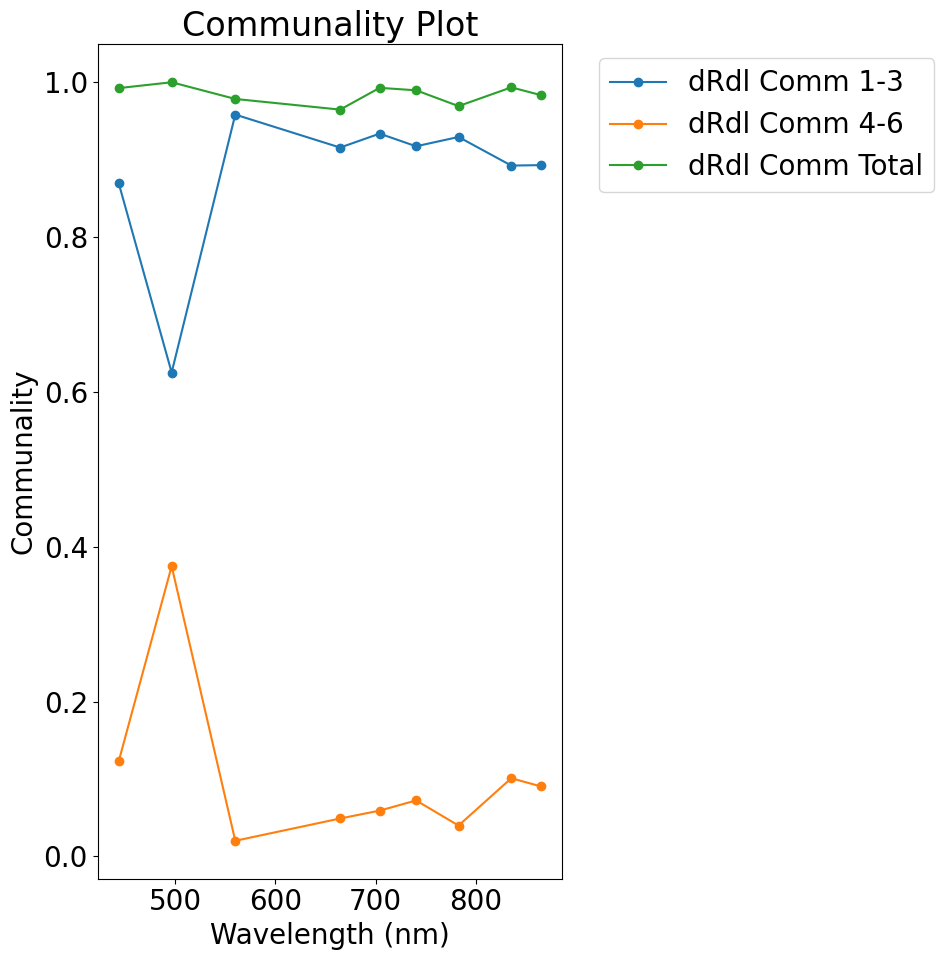

In [ ]:
comm_graph_fn = f'/content/gdrive/My Drive/KSU_VPCA_Outputs/6VPCA_{siteName_2char}_{imageID}_CommunalityGraph_{bandCombo}.png'

# Set the default font size in matplotlib
mpl.rcParams.update({'font.size': 20})

# Use the lambda operator to convert each element to float to ensure proper plotting.
x1 = components['Comm_1-3'].head(9).apply(lambda x1: float(x1))
# x2 = components['Comm_1-3'].tail(8).apply(lambda x2: float(x2))
x3 = components['Comm_4-6'].head(9).apply(lambda x3: float(x3))
# x4 = components['Comm_4-6'].tail(8).apply(lambda x4: float(x4))
x5 = components['Comm_tot'].head(9).apply(lambda x5: float(x5))
# x6 = components['Comm_tot'].tail(8).apply(lambda x6: float(x6))

y = wl.getInfo()

comm = plt.figure(figsize = (10,10))

plt.title('Communality Plot')
plt.plot(y, x1, 'o-')
# plt.plot(y, x2, 'o-')
plt.plot(y, x3, 'o-')
# plt.plot(y, x4, 'o-')
plt.plot(y, x5, 'o-')
# plt.plot(y, x6, 'o-')
#plt.legend(labels = ['Ref Comm 1-3','dRdl Comm 1-3','Ref Comm 4-6','dRdl Comm 4-6','Ref Comm Total','dRdl Comm Total'], loc = 'upper right')# 2 or 3 y axis plot: have to give it both x and y.
plt.legend(labels = ['dRdl Comm 1-3','dRdl Comm 4-6','dRdl Comm Total'], bbox_to_anchor=(1.05, 1.0), loc='upper left')# 2 or 3 y axis plot: have to give it both x and y.
plt.xlabel('Wavelength (nm)')
plt.ylabel('Communality')
plt.tight_layout()
plt.savefig(comm_graph_fn, dpi = 300)
plt.show()
# Apply all 20 of the eigenvalues on one side, plot all of the variance explained.

Plot eigenvalues vs. rank with fractional variance as labels

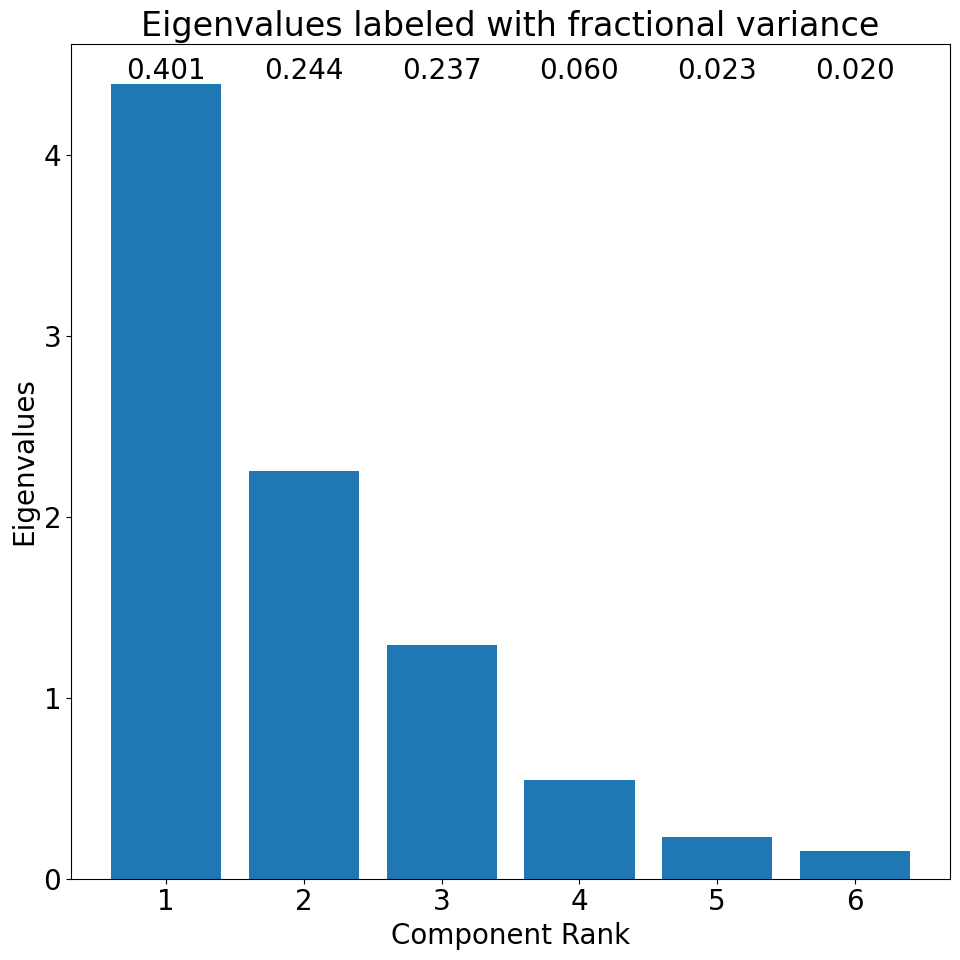

In [ ]:
var_graph_fn = f'/content/gdrive/My Drive/KSU_VPCA_Outputs/6VPCA_{siteName_2char}_{imageID}_VarianceGraph_{bandCombo}.png'

rank = [ 1, 2, 3, 4, 5, 6]
eigs = eigs_and_fracs.loc[9][1:7].tolist()
fracs = eigs_and_fracs.loc[10][1:7].tolist()
fig, ax = plt.subplots(figsize = (10,10))

plt.title('Eigenvalues labeled with fractional variance')
bar_graph = ax.bar(rank, eigs)

#ax.bar_label(bar_graph, labels = [frac.round(4) for frac in fracs], padding = 3)

# Now plot the fractional variance as plot labels
# zip joins x and y coordinates in pairs
for x,y in zip(rank,fracs):
     label = "{:.3f}".format(y) # I can plot the eigenvalue, but want to plot fractional variance, but fracs is a list of strings
     plt.annotate(label,
                  (x,0.98*max(eigs)), # this is the point to label which is defined by x and a fraction of the maximum of the eigenvalues
                  textcoords="offset points", # how to position the text
                  xytext=(0,15), # distance from text to points (x,y)
                  ha='center') # horizontal alignment can be left, right or center

plt.xlabel('Component Rank')
plt.ylabel('Eigenvalues')
plt.tight_layout()
plt.savefig(var_graph_fn, dpi = 300)
plt.show()

Plot VPC1 Commponent loadings

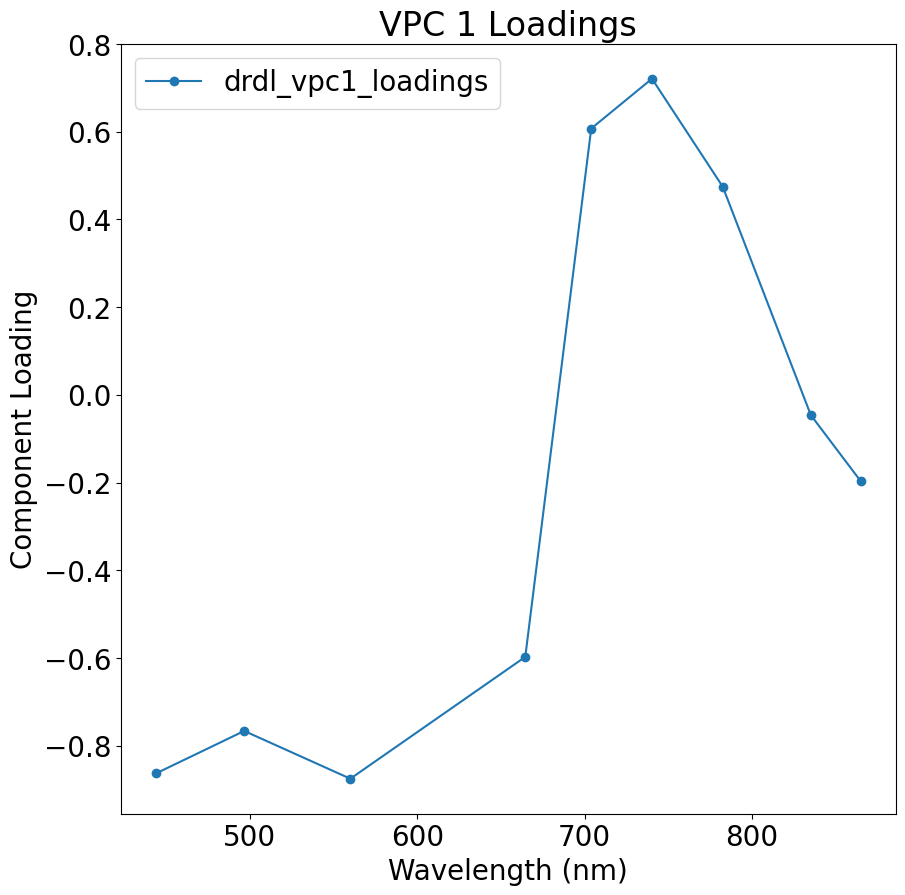

In [ ]:
vpc1_graph_fn = f'/content/gdrive/My Drive/KSU_VPCA_Outputs/6VPCA_{siteName_2char}_{imageID}_vpc1LoadingsGraph_{bandCombo}.png'

x1 = components['component 1'].head(9)
#print(x1)
# x2 = components['component 1'].tail(8)

y = wl.getInfo()
#print(y)

vpc1 = plt.figure(figsize = (10,10))

plt.title('VPC 1 Loadings')
plt.plot(y, x1, 'o-')
# plt.plot(y, x2, 'o-')
plt.legend(labels = ['drdl_vpc1_loadings'], loc = 'best')# 2 or 3 y axis plot: have to give it both x and y.
#plt.legend(labels = ['ref_vpc1_loadings','drdl_vpc1_loadings'], bbox_to_anchor=(1.05, 1.0), loc='upper left')# 2 or 3 y axis plot: have to give it both x and y.
plt.xlabel('Wavelength (nm)')
plt.ylabel('Component Loading')
plt.savefig(vpc1_graph_fn, dpi = 300)
plt.show()
# Apply all 20 of the eigenvalues on one side, plot all of the variance explained.

Plot VPC2 Commponent loadings

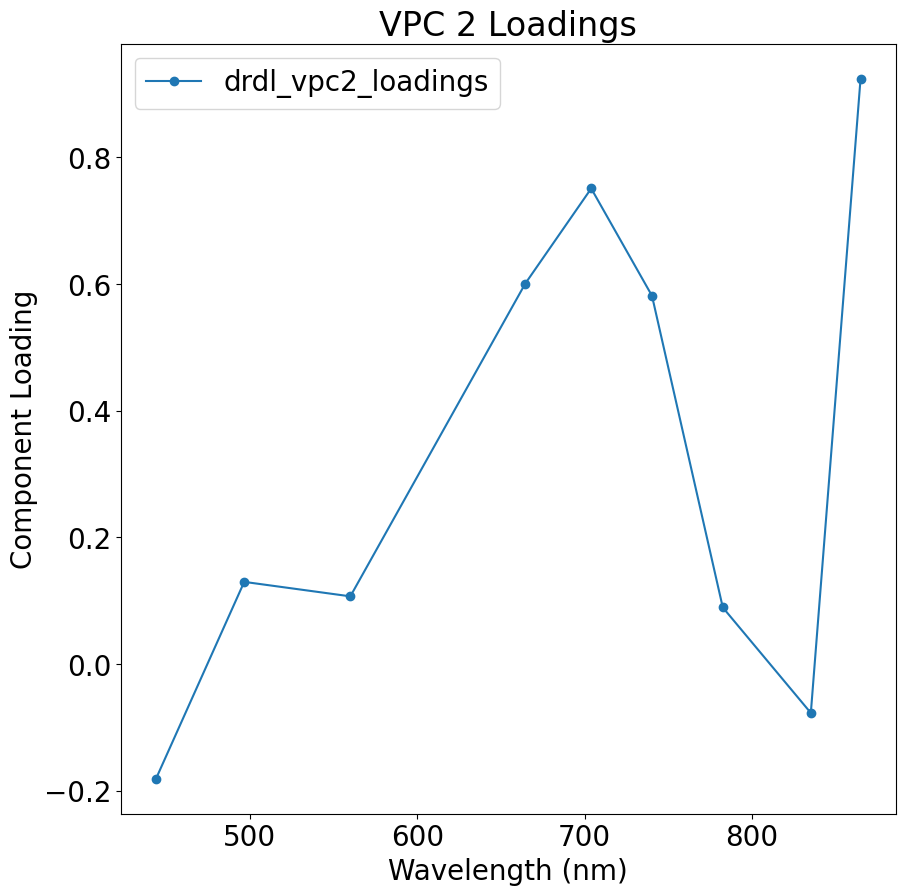

In [ ]:
vpc2_graph_fn = f'/content/gdrive/My Drive/KSU_VPCA_Outputs/6VPCA_{siteName_2char}_{imageID}_vpc2LoadingsGraph_{bandCombo}.png'

# Set wavelenth axes limits to 400-900
# Set component loading limits to -1 to 1

x1 = components['component 2'].head(9)
# x2 = components['component 2'].tail(8)

# y = wl.getInfo()

vpc2 = plt.figure(figsize = (10,10))

plt.title('VPC 2 Loadings')
plt.plot(y, x1, 'o-')
# plt.plot(y, x2, 'o-')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Component Loading')
plt.legend(labels = ['drdl_vpc2_loadings'], loc = 'best')# 2 or 3 y axis plot: have to give it both x and y.
#plt.legend(labels = ['ref_vpc2_loadings','drdl_vpc2_loadings'], bbox_to_anchor=(1.05, 1.0), loc='upper left')# 2 or 3 y axis plot: have to give it both x and y.
plt.savefig(vpc2_graph_fn, dpi = 300)
plt.show()
# Apply all 20 of the eigenvalues on one side, plot all of the variance explained.

Plot VPC3 Commponent loadings

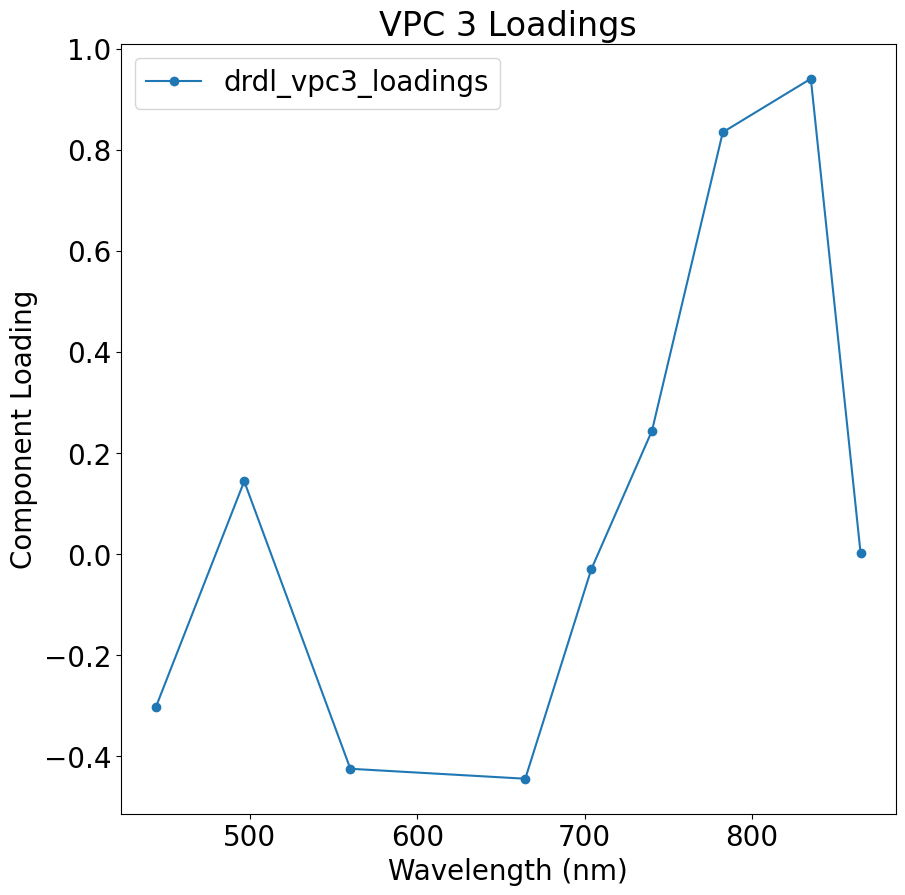

In [ ]:
vpc3_graph_fn = f'/content/gdrive/My Drive/KSU_VPCA_Outputs/6VPCA_{siteName_2char}_{imageID}_vpc3LoadingsGraph_{bandCombo}.png'

x1 = components['component 3'].head(9)
# x2 = components['component 3'].tail(8)

# y = wl.getInfo()

vpc3 = plt.figure(figsize = (10,10))

plt.title('VPC 3 Loadings')
plt.plot(y, x1, 'o-')
# plt.plot(y, x2, 'o-')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Component Loading')
plt.legend(labels = ['drdl_vpc3_loadings'], loc = 'best')# 2 or 3 y axis plot: have to give it both x and y.
#plt.legend(labels = ['ref_vpc3_loadings','drdl_vpc3_loadings'], bbox_to_anchor=(1.05, 1.0), loc='upper left')# 2 or 3 y axis plot: have to give it both x and y.
plt.savefig(vpc3_graph_fn, dpi = 300)
plt.show()
# Apply all 20 of the eigenvalues on one side, plot all of the variance explained.

Plot VPC4 Commponent loadings

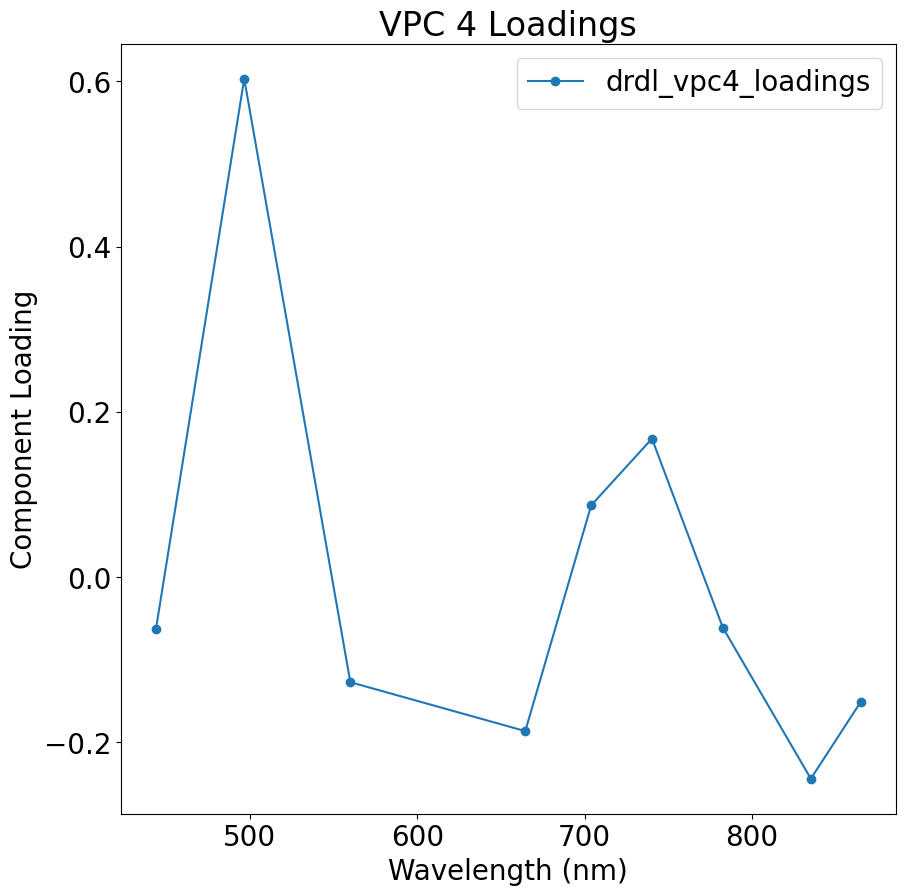

In [ ]:
vpc4_graph_fn = f'/content/gdrive/My Drive/KSU_VPCA_Outputs/6VPCA_{siteName_2char}_{imageID}_vpc4LoadingsGraph_{bandCombo}.png'

x1 = components['component 4'].head(9)
# x2 = components['component 4'].tail(8)

# y = wl.getInfo()

vpc4 = plt.figure(figsize = (10,10))

plt.title('VPC 4 Loadings')
plt.plot(y, x1, 'o-')
# plt.plot(y, x2, 'o-')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Component Loading')
plt.legend(labels = ['drdl_vpc4_loadings'], loc = 'best')# 2 or 3 y axis plot: have to give it both x and y.
#plt.legend(labels = ['ref_vpc4_loadings','drdl_vpc4_loadings'], bbox_to_anchor=(1.05, 1.0), loc='upper left')# 2 or 3 y axis plot: have to give it both x and y.
plt.savefig(vpc4_graph_fn, dpi = 300)
plt.show()
# Apply all 20 of the eigenvalues on one side, plot all of the variance explained.

Plot VPC5 Commponent loadings

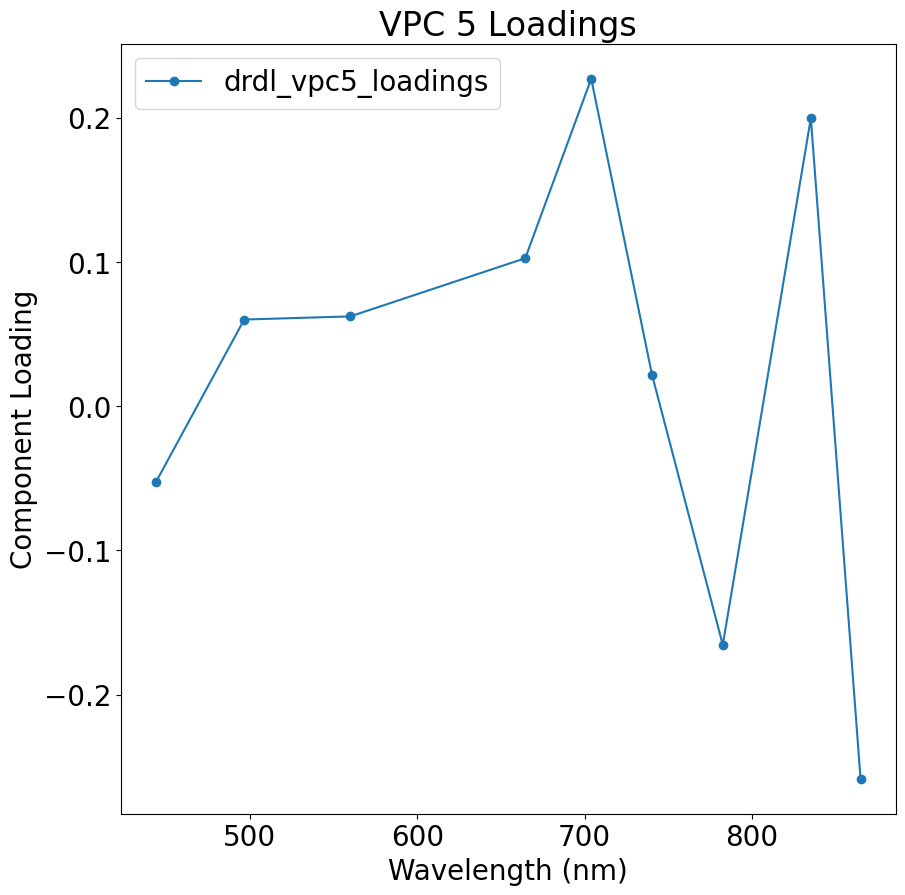

In [ ]:
vpc5_graph_fn = f'/content/gdrive/My Drive/KSU_VPCA_Outputs/6VPCA_{siteName_2char}_{imageID}_vpc5LoadingsGraph_{bandCombo}.png'

x1 = components['component 5'].head(9)
# x2 = components['component 5'].tail(8)

# y = wl.getInfo()

vpc5 = plt.figure(figsize = (10,10))

plt.title('VPC 5 Loadings')
plt.plot(y, x1, 'o-')
# plt.plot(y, x2, 'o-')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Component Loading')
plt.legend(labels = ['drdl_vpc5_loadings'], loc = 'best')# 2 or 3 y axis plot: have to give it both x and y.
#plt.legend(labels = ['ref_vpc5_loadings','drdl_vpc5_loadings'], bbox_to_anchor=(1.05, 1.0), loc='upper left')# 2 or 3 y axis plot: have to give it both x and y.
plt.savefig(vpc5_graph_fn, dpi = 300)
plt.show()
# Apply all 20 of the eigenvalues on one side, plot all of the variance explained.

Plot VPC6 Commponent loadings

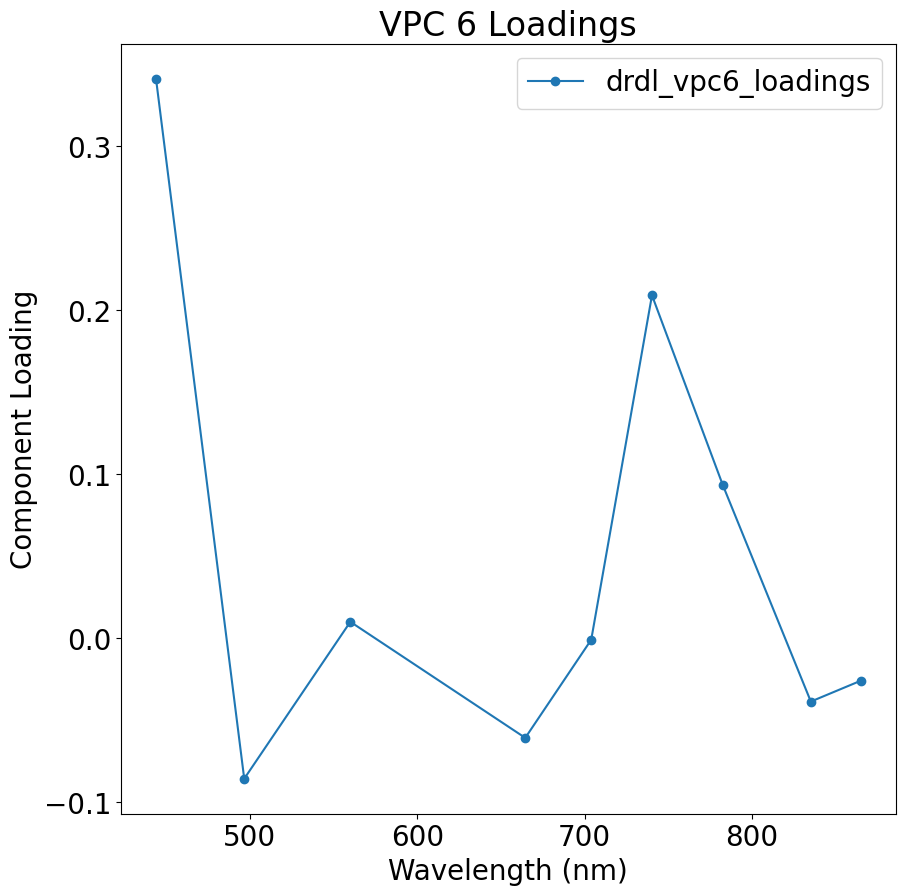

In [ ]:
vpc6_graph_fn = f'/content/gdrive/My Drive/KSU_VPCA_Outputs/6VPCA_{siteName_2char}_{imageID}_vpc6LoadingsGraph_{bandCombo}.png'

x1 = components['component 6'].head(9)
# x2 = components['component 6'].tail(8)

# y = wl.getInfo()

vpc6 = plt.figure(figsize = (10,10))

plt.title('VPC 6 Loadings')
plt.plot(y, x1, 'o-')
# plt.plot(y, x2, 'o-')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Component Loading')
plt.legend(labels = ['drdl_vpc6_loadings'], loc = 'best')# 2 or 3 y axis plot: have to give it both x and y.
#plt.legend(labels = ['ref_vpc6_loadings','drdl_vpc6_loadings'], bbox_to_anchor=(1.05, 1.0), loc='upper left')# 2 or 3 y axis plot: have to give it both x and y.
plt.savefig(vpc6_graph_fn, dpi = 300)
plt.show()
# Apply all 20 of the eigenvalues on one side, plot all of the variance explained.

# VPCA 1 GEE folium map

In [ ]:
pc1_minMax = minAndMax(finalImage.select('PC_1'),roi)
#mapid_3 = finalImage.select('PC_1').getMapId({'palette':spectral,'min':pc1_minMax.get('p2'),'max':pc1_minMax.get('p98')}) # Where "pc1" is specified, switch this out with whatever you want to visaulize.
mapid_3 = finalImage.select('PC_1').getMapId({'palette':BrBG_r,'min':pc1_minMax.get('p2'),'max':pc1_minMax.get('p98')}) # Where "pc1" is specified, switch this out with whatever you want to visaulize.

map = folium.Map(location = [lon_lat[1],lon_lat[0]], height = 1000, width = 1000, zoom_start = 10.0)
# Add original image to map.
orig.add_to(map)
# Add component to map.
folium.TileLayer(
    tiles=mapid_3['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
# try adding a color bar
  ).add_to(map)

# Add a title to the map, including image Id label
title_html = f'''
             <h3 align="left" style="font-size:16px"> <b>Sentinel 2 A/B MSI {siteName} VPC 1: {imageID}</b></h3>
             '''
map.get_root().html.add_child(folium.Element(title_html))

map

# VPCA 2 GEE folium map

In [ ]:
pc2_minMax = minAndMax(finalImage.select('PC_2'),roi)
mapid_4 = finalImage.select('PC_2').getMapId({'palette':spectral,'min':pc2_minMax.get('p2'),'max':pc2_minMax.get('p98')}) # Where "pc2" is specified, switch this out with whatever you want to visaulize.
#mapid_4 = finalImage.select('PC_2').getMapId({'palette':BrBG,'min':pc2_minMax.get('p2'),'max':pc2_minMax.get('p98')}) # Where "pc2" is specified, switch this out with whatever you want to visaulize.

map = folium.Map(location = [lon_lat[1],lon_lat[0]], height = 1000, width = 1000, zoom_start = 10.0)
# Add original image to map.
orig.add_to(map)
# Add component to map.
folium.TileLayer(
    tiles=mapid_4['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
  ).add_to(map)

map.add_child(folium.LayerControl())

# Add a title to the map, including image Id label
title_html = f'''
             <h3 align="left" style="font-size:16px"> <b>Sentinel 2 A/B MSI {siteName} VPC 2: {imageID}</b></h3>
             '''
map.get_root().html.add_child(folium.Element(title_html))
map

# VPCA 3 GEE folium map

In [ ]:
pc3_minMax = minAndMax(finalImage.select('PC_3'),roi)
mapid_5 = finalImage.select('PC_3').getMapId({'palette':spectral,'min':pc3_minMax.get('p2'),'max':pc3_minMax.get('p98')}) # Where "pc3" is specified, switch this out with whatever you want to visaulize.
#mapid_5 = finalImage.select('PC_3').getMapId({'palette':BrBG_r,'min':pc3_minMax.get('p2'),'max':pc3_minMax.get('p98')}) # Where "pc3" is specified, switch this out with whatever you want to visaulize.

map = folium.Map(location = [lon_lat[1],lon_lat[0]], height = 1000, width = 1000, zoom_start = 10.0)
# Add original image to map.
orig.add_to(map)
# Add component to map.
folium.TileLayer(
    tiles=mapid_5['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
  ).add_to(map)
map.add_child(folium.LayerControl())

# Add a title to the map, including image Id label
title_html = f'''
             <h3 align="left" style="font-size:16px"> <b>Sentinel 2 A/B MSI {siteName} VPC 3: {imageID}</b></h3>
             '''
map.get_root().html.add_child(folium.Element(title_html))
map

In [ ]:
pc4_minMax = minAndMax(finalImage.select('PC_4'),roi)
mapid_6 = finalImage.select('PC_4').getMapId({'palette':spectral,'min':pc4_minMax.get('p2'),'max':pc4_minMax.get('p98')}) # Where "pc4" is specified, switch this out with whatever you want to visaulize.
#mapid_6 = finalImage.select('PC_4').getMapId({'palette':BrBG,'min':pc4_minMax.get('p2'),'max':pc4_minMax.get('p98')}) # Where "pc4" is specified, switch this out with whatever you want to visaulize.

map = folium.Map(location = [lon_lat[1],lon_lat[0]], height = 1000, width = 1000, zoom_start = 10.0)
# Add original image to map.
orig.add_to(map)
# Add component to map.
folium.TileLayer(
    tiles=mapid_6['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
  ).add_to(map)
map.add_child(folium.LayerControl())

# Add a title to the map, including image Id label
title_html = f'''
             <h3 align="left" style="font-size:16px"> <b>Sentinel 2 A/B MSI {siteName} VPC 4: {imageID}</b></h3>
             '''
map.get_root().html.add_child(folium.Element(title_html))
map

In [ ]:
pc5_minMax = minAndMax(finalImage.select('PC_5'),roi)
mapid_7 = finalImage.select('PC_5').getMapId({'palette':spectral,'min':pc5_minMax.get('p2'),'max':pc5_minMax.get('p98')}) # Where "pc5" is specified, switch this out with whatever you want to visaulize.
#mapid_7 = finalImage.select('PC_5').getMapId({'palette':BrBG,'min':pc5_minMax.get('p2'),'max':pc5_minMax.get('p98')}) # Where "pc5" is specified, switch this out with whatever you want to visaulize.

map = folium.Map(location = [lon_lat[1],lon_lat[0]], height = 1000, width = 1000, zoom_start = 10.0)
# Add original image to map.
orig.add_to(map)
# Add component to map.
folium.TileLayer(
    tiles=mapid_7['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
  ).add_to(map)
map.add_child(folium.LayerControl())

# Add a title to the map, including image Id label
title_html = f'''
             <h3 align="left" style="font-size:16px"> <b>Sentinel 2 A/B MSI {siteName} VPC 5: {imageID}</b></h3>
             '''
map.get_root().html.add_child(folium.Element(title_html))
map

In [ ]:
pc6_minMax = minAndMax(finalImage.select('PC_6'),roi)
mapid_8 = finalImage.select('PC_6').getMapId({'palette':spectral_r,'min':pc6_minMax.get('p2'),'max':pc6_minMax.get('p98')}) # Where "pc6" is specified, switch this out with whatever you want to visaulize.
#mapid_8 = finalImage.select('PC_6').getMapId({'palette':BrBG_r,'min':pc6_minMax.get('p2'),'max':pc6_minMax.get('p98')}) # Where "pc6" is specified, switch this out with whatever you want to visaulize.

map = folium.Map(location = [lon_lat[1],lon_lat[0]], height = 1000, width = 1000, zoom_start = 10.0)
# Add original image to map.
orig.add_to(map)
# Add component to map.
folium.TileLayer(
    tiles=mapid_8['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
  ).add_to(map)
map.add_child(folium.LayerControl())

# Add a title to the map, including image Id label
title_html = f'''
             <h3 align="left" style="font-size:16px"> <b>Sentinel 2 A/B MSI {siteName} VPC 6: {imageID}</b></h3>
             '''
map.get_root().html.add_child(folium.Element(title_html))
map


# VPCA Sum3 GEE folium map

In [ ]:
sum3_minMax = minAndMax(pc_sum3,roi)
#mapid_9 = pc_sum3.getMapId({'palette':spectral,'min':sum3_minMax.get('p2'),'max':sum3_minMax.get('p98')}) # Where "pc_sum3" is specified, switch this out with whatever you want to visaulize.
mapid_9 = pc_sum3.getMapId({'palette':spectral_r,'min':sum3_minMax.get('p2'),'max':sum3_minMax.get('p98')}) # Where "pc_sum3" is specified, switch this out with whatever you want to visaulize.

map = folium.Map(location = [lon_lat[1],lon_lat[0]], height = 1000, width = 1000, zoom_start = 10.0)
# Add original image to map.
orig.add_to(map)
# Add component to map.
folium.TileLayer(
    tiles=mapid_9['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
  ).add_to(map)

map.add_child(folium.LayerControl())

# Add a title to the map, including image Id label
title_html = f'''
             <h3 align="left" style="font-size:16px"> <b>Sentinel 2 A/B MSI {siteName} VPC 1-3 sum: {imageID}</b></h3>
             '''
map.get_root().html.add_child(folium.Element(title_html))

map

## VPCA Sum6 GEE folium map

In [ ]:
sum6_minMax = minAndMax(pc_sum6,roi)
#mapid_10 = pc_sum6.getMapId({'palette':spectral,'min':sum6_minMax.get('p2'),'max':sum6_minMax.get('p98')}) # Where "pc_sum6" is specified, switch this out with whatever you want to visaulize.
mapid_10 = pc_sum6.getMapId({'palette':spectral_r,'min':sum6_minMax.get('p2'),'max':sum6_minMax.get('p98')}) # Where "pc_sum6" is specified, switch this out with whatever you want to visaulize.

map = folium.Map(location = [lon_lat[1],lon_lat[0]], height = 1000, width = 1000, zoom_start = 10.0)
# Add original image to map.
orig.add_to(map)
# Add component to map.
folium.TileLayer(
    tiles=mapid_10['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
  ).add_to(map)

map.add_child(folium.LayerControl())

# Add a title to the map, including image Id label
title_html = f'''
             <h3 align="left" style="font-size:16px"> <b>Sentinel 2 A/B MSI {siteName} VPC 1-6 sum: {imageID}</b></h3>
             '''
map.get_root().html.add_child(folium.Element(title_html))

map

## VPCA-based SAV: Submerged Aquatic Vegetation estimated plot

In [ ]:
sav_minMax = minAndMax(pc_SAV,roi)
#mapid_11 = pc_SAV.getMapId({'palette':spectral,'min':sav_minMax.get('p2'),'max':sav_minMax.get('p98')}) # Where "pc_SAV" is specified, switch this out with whatever you want to visaulize.
mapid_11 = pc_SAV.getMapId({'palette':BrBG,'min':sav_minMax.get('p2'),'max':sav_minMax.get('p98')}) # Where "pc_SAV" is specified, switch this out with whatever you want to visaulize.

map = folium.Map(location = [lon_lat[1],lon_lat[0]], height = 1000, width = 1000, zoom_start = 10.0)
# Add original image to map.
orig.add_to(map)
# Add component to map.
folium.TileLayer(
    tiles=mapid_11['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
  ).add_to(map)

map.add_child(folium.LayerControl())

# Add a title to the map, including image Id label
title_html = f'''
             <h3 align="left" style="font-size:16px"> <b>Sentinel 2 A/B MSI {siteName} VPC-based SAV: {imageID}</b></h3>
             '''
map.get_root().html.add_child(folium.Element(title_html))

map

# VPCA-based SeaGrass estimated plot

In [ ]:
seaGrass_minMax = minAndMax(pc_SeaGrass,roi)
#mapid_12 = pc_SeaGrass.getMapId({'palette':spectral,'min':seaGrass_minMax.get('p2'),'max':seaGrass_minMax.get('p98')}) # Where "pc_SAV" is specified, switch this out with whatever you want to visaulize.
mapid_12 = pc_SeaGrass.getMapId({'palette':BrBG,'min':seaGrass_minMax.get('p2'),'max':seaGrass_minMax.get('p98')}) # Where "pc_SAV" is specified, switch this out with whatever you want to visaulize.

map = folium.Map(location = [lon_lat[1],lon_lat[0]], height = 1000, width = 1000, zoom_start = 10.0)
# Add original image to map.
orig.add_to(map)
# Add component to map.
folium.TileLayer(
    tiles=mapid_12['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
  ).add_to(map)

map.add_child(folium.LayerControl())

# Add a title to the map, including image Id label
title_html = f'''
             <h3 align="left" style="font-size:16px"> <b>Sentinel 2 A/B MSI {siteName} VPC-based SeaGrass: {imageID}</b></h3>
             '''
map.get_root().html.add_child(folium.Element(title_html))

map

Combined Communality and Variance plot

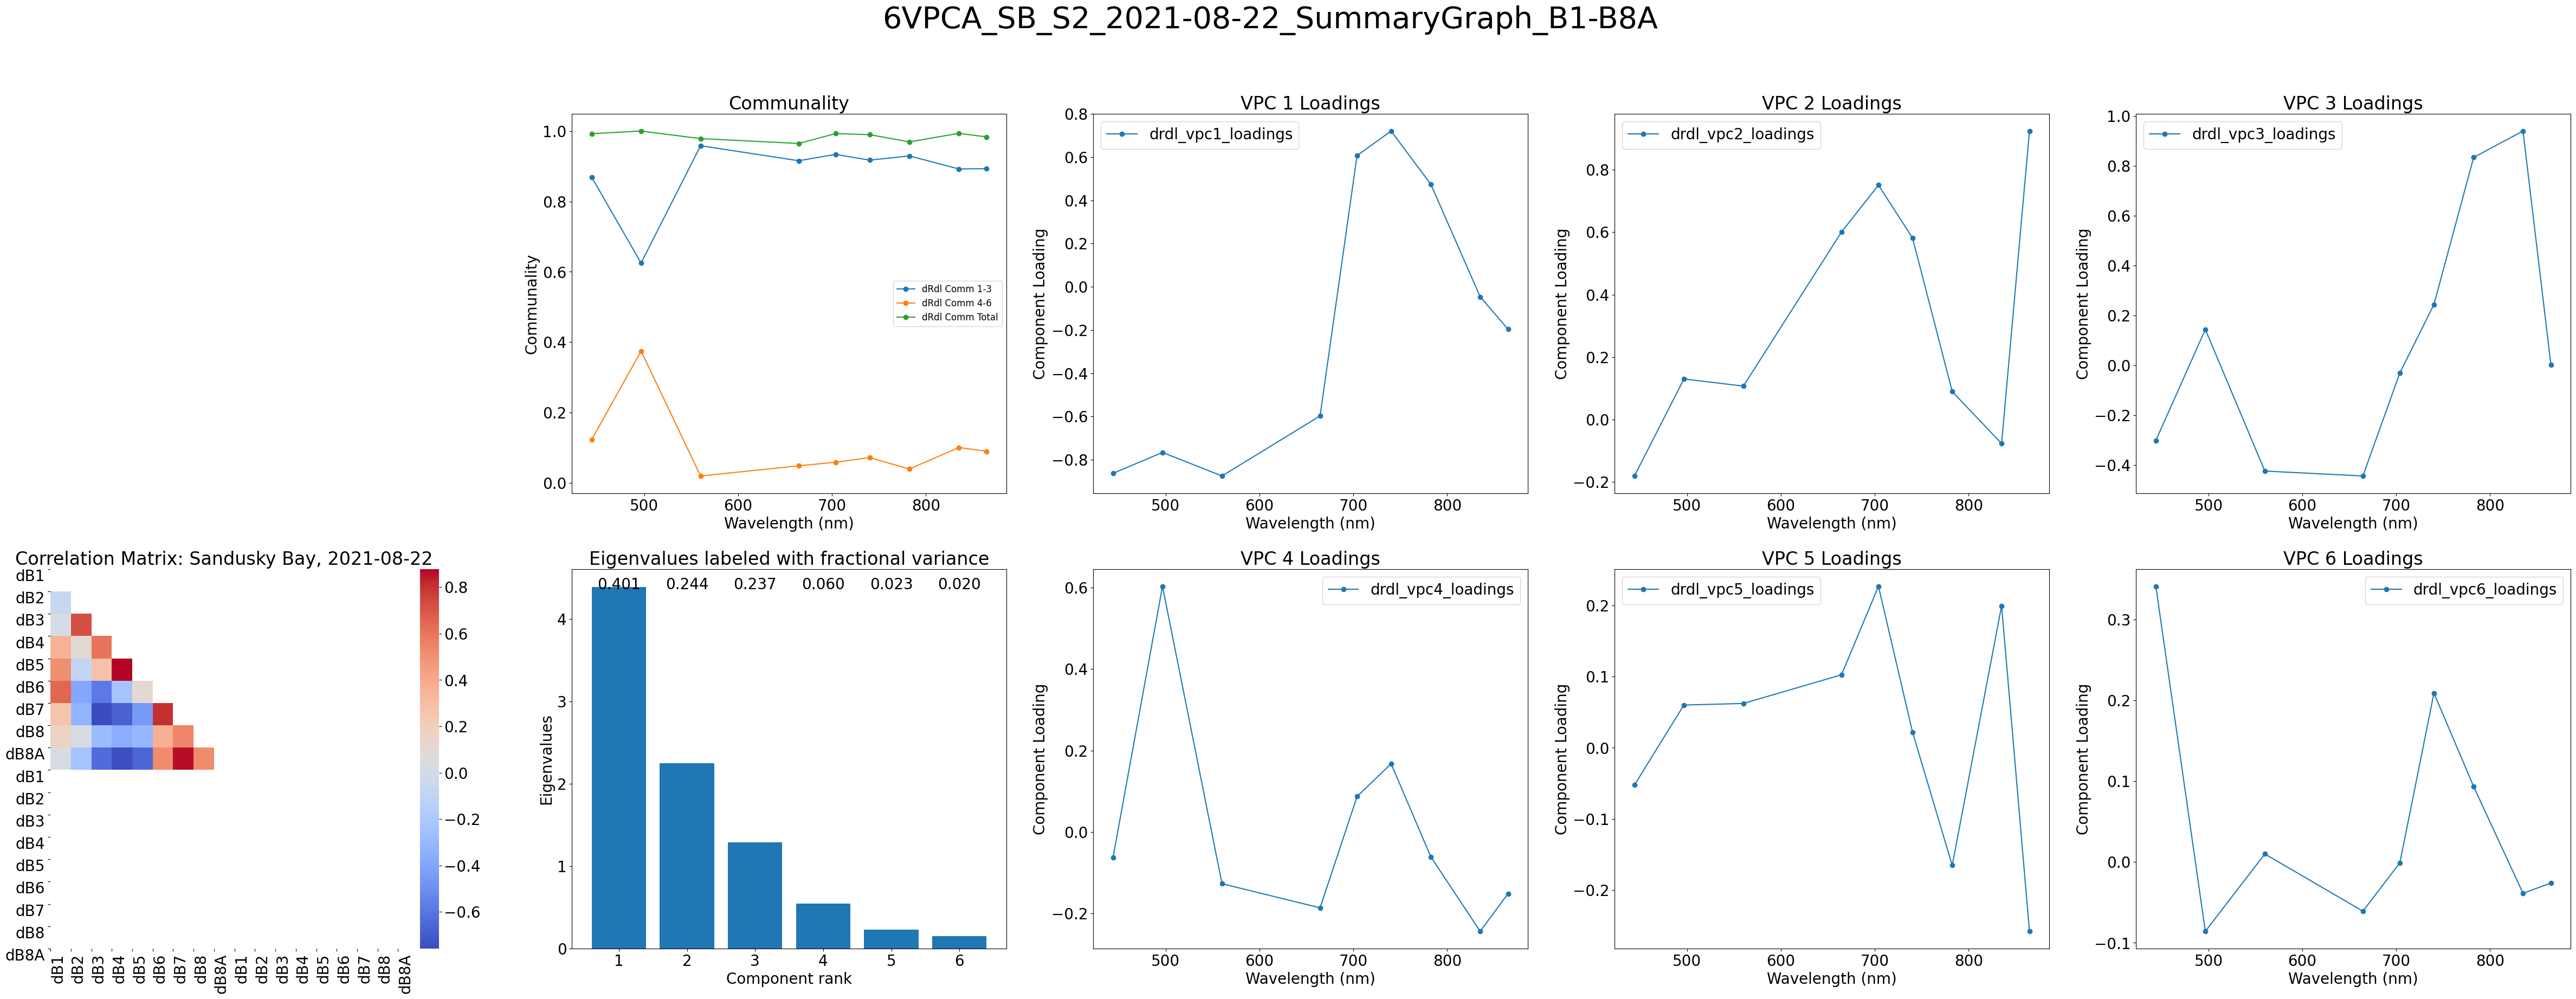

In [ ]:
summary_plt_fn = f'/content/gdrive/My Drive/KSU_VPCA_Outputs/6VPCA_{siteName_2char}_{imageID}_SummaryGraph_{bandCombo}.png'

# Initilize the multipanel plot

fig, axs = plt.subplots(2,5, figsize=(60,20))
plt.suptitle(f'6VPCA_{siteName_2char}_{imageID}_SummaryGraph_{bandCombo}', fontsize=40)

# Panel [0,0] is used to provide space for the legend of the Communality plot

axs[0,0].axis('off')

# Generate the correlation matrix plot panel
# Panel [1,0] is used for the correlation matix plot

# Use this code to allow for differing number of bands processed
labels = [f'd{non_ee_band_list[x]}' for x in range(band_list_early_length)] + [f'd{non_ee_band_list[x]}' for x in range(band_list_early_length)]

axs[1,0].title.set_text(f"Correlation Matrix: {siteName.replace('_', ' ')}, {imageID.replace('S2_','')}")

sea.heatmap(corr_ls, square = False, mask = mask, cmap = 'coolwarm', ax = axs[1,0])
#heat.set_xticklabels(labels)
#heat.set_yticklabels(labels)
#for tick in heat.get_yticklabels():
#  tick.set_rotation(0)

# use the following two lines of code to generate a symmetric correlation heatmap
# axs[1,0].imshow(corr_ls, cmap='coolwarm')
# fig.colorbar(axs[1,0].imshow(corr_ls, cmap='coolwarm'), ax=[axs[1, 0]], location='right', shrink=0.8).mappable.set_clim(-1,1)

axs[1,0].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17])
axs[1,0].set_xticklabels(labels, rotation='vertical', ha='left')
axs[1,0].set_yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17])
axs[1,0].set_yticklabels(labels, rotation='horizontal', va='top')

# Now Generate the Communality plot panel

# Use the lambda operator to convert each element to float to ensure proper plotting.
x1 = components['Comm_1-3'].head(9).apply(lambda x1: float(x1))
# x2 = components['Comm_1-3'].tail(8).apply(lambda x2: float(x2))
x3 = components['Comm_4-6'].head(9).apply(lambda x3: float(x3))
# x4 = components['Comm_4-6'].tail(8).apply(lambda x4: float(x4))
x5 = components['Comm_tot'].head(9).apply(lambda x5: float(x5))
# x6 = components['Comm_tot'].tail(8).apply(lambda x6: float(x6))

y = wl.getInfo()

axs[0,1].title.set_text('Communality')
axs[0,1].plot(y, x1, 'o-')
# axs[0,1].plot(y, x2, 'o-')
axs[0,1].plot(y, x3, 'o-')
# axs[0,1].plot(y, x4, 'o-')
axs[0,1].plot(y, x5, 'o-')
# axs[0,1].plot(y, x6, 'o-')
axs[0,1].legend(labels = ['dRdl Comm 1-3','dRdl Comm 4-6','dRdl Comm Total'], bbox_to_anchor=(-0.65, 1.0), loc='upper left')
axs[0,1].legend(labels = ['dRdl Comm 1-3','dRdl Comm 4-6','dRdl Comm Total'], loc='center right', fontsize=12)
axs[0,1].set(xlabel='Wavelength (nm)', ylabel='Communality')

# Now generate the Variance plot panel

rank = [ 1, 2, 3, 4, 5, 6]
eigs = eigs_and_fracs.loc[9][1:7].tolist()
fracs = eigs_and_fracs.loc[10][1:7].tolist()

axs[1,1].title.set_text('Eigenvalues labeled with fractional variance')
axs[1,1].bar_graph = axs[1,1].bar(rank, eigs)

# Now plot the fractional variance as plot labels
# zip joins x and y coordinates in pairs
for x,y in zip(rank,fracs):
     label = "{:.3f}".format(y) # I can plot the eigenvalue, but want to plot fractional variance, but fracs is a list of strings
     axs[1,1].annotate(label,
                  (x,0.98*max(eigs)), # this is the point to label which is defined by x and a fraction of the maximum of the eigenvalues
                  textcoords="offset points", # how to position the text
                  xytext=(0,7), # distance from text to points (x,y)
                  ha='center') # horizontal alignment can be left, right or center

axs[1,1].set(xlabel='Component rank', ylabel='Eigenvalues')

# Top row of panels
#Reset y axis for wavelength
y = wl.getInfo()

# Now plot VPC1

x7 = components['component 1'].head(9)

# x8 = components['component 1'].tail(8)

# Comment out the following if flipping the axis
axs[0,2].title.set_text('VPC 1 Loadings')

#Flip the Axes if so desired
#axs[0,2].title.set_text('VPC -1 Loadings')
#axs[0,2].invert_yaxis()

axs[0,2].plot(y, x7, 'o-')
# axs[0,2].plot(y, x8, 'o-')
axs[0,2].legend(labels = ['drdl_vpc1_loadings'], loc = 'best')
axs[0,2].set(xlabel='Wavelength (nm)', ylabel='Component Loading')

# Now plot VPC2

x9 = components['component 2'].head(9)
# x10 = components['component 2'].tail(8)


# Comment out the following if flipping the axis
axs[0,3].title.set_text('VPC 2 Loadings')

#Flip the Axes if so desired
#axs[0,3].title.set_text('VPC -2 Loadings')
#axs[0,3].invert_yaxis()

axs[0,3].plot(y, x9, 'o-')
# axs[0,3].plot(y, x10, 'o-')
axs[0,3].legend(labels = ['drdl_vpc2_loadings'], loc = 'best')
axs[0,3].set(xlabel='Wavelength (nm)', ylabel='Component Loading')

# Now plot VPC3

x11 = components['component 3'].head(9)
# x12 = components['component 3'].tail(8)


# Comment out the following if flipping the axis
axs[0,4].title.set_text('VPC 3 Loadings')

#Flip the Axes if so desired
#axs[0,4].title.set_text('VPC -3 Loadings')
#axs[0,4].invert_yaxis()

axs[0,4].plot(y, x11, 'o-')
# axs[0,4].plot(y, x12, 'o-')
axs[0,4].legend(labels = ['drdl_vpc3_loadings'], loc = 'best')
axs[0,4].set(xlabel='Wavelength (nm)', ylabel='Component Loading')

# Bottom Row of panels
# Now plot VPC4

x13 = components['component 4'].head(9)
# x14 = components['component 4'].tail(8)


# Comment out the following if flipping the axis
axs[1,2].title.set_text('VPC 4 Loadings')

#Flip the Axes if so desired
#axs[1,2].title.set_text('VPC -4 Loadings')
#axs[1,2].invert_yaxis()

axs[1,2].plot(y, x13, 'o-')
# axs[1,2].plot(y, x14, 'o-')
axs[1,2].legend(labels = ['drdl_vpc4_loadings'], loc = 'best')
axs[1,2].set(xlabel='Wavelength (nm)', ylabel='Component Loading')

# Now plot VPC5

x15 = components['component 5'].head(9)
# x16 = components['component 5'].tail(8)


# Comment out the following if flipping the axis
axs[1,3].title.set_text('VPC 5 Loadings')

#Flip the Axes if so desired
#axs[1,3].title.set_text('VPC -5 Loadings')
#axs[1,3].invert_yaxis()

axs[1,3].plot(y, x15, 'o-')
# axs[1,3].plot(y, x16, 'o-')
axs[1,3].legend(labels = ['drdl_vpc5_loadings'], loc = 'best')
axs[1,3].set(xlabel='Wavelength (nm)', ylabel='Component Loading')

# Now plot VPC6

x17 = components['component 6'].head(9)
# x18 = components['component 6'].tail(8)


# Comment out the following if flipping the axis
axs[1,4].title.set_text('VPC 6 Loadings')

#Flip the Axes if so desired
#axs[1,4].title.set_text('VPC -6 Loadings')
#axs[1,4].invert_yaxis()

axs[1,4].plot(y, x17, 'o-')
# axs[1,4].plot(y, x18, 'o-')
axs[1,4].legend(labels = ['drdl_vpc6_loadings'], loc = 'best')
axs[1,4].set(xlabel='Wavelength (nm)', ylabel='Component Loading')

plt.savefig(summary_plt_fn, dpi = 300)
plt.show()